# Introdução à Inteligência Artificial

**Unidade 2**

Discente: Samnatha Dantas Medeiros

> Dataset utilizado: https://github.com/tmfilho/akcdata/blob/master/data/akc-data-latest.csv

## Ambiente, funções e _misc_
A seção a seguir contém a inicialização deste notebook (bibliotecas a serem utilizadas, funções de propósitos específicos e algumas variáveis para ficarem 'separadas' dos blocos adjacentes).

In [60]:
#pip install imbalanced-learn

In [181]:
# Dependências
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, accuracy_score)

In [4]:
# Funções que serão utilizadas ao longo do pré-processamento de dados
# parãmetros: dataframe, coluna numérica, coluna que armazena valor do grupo (toy, herding, sporting)

'''
Esta função substitui valores não-numéricos(caso hajam) e nulos 
de colunas numéricas do dataframe pela mediana
de suas colunas de acordo com o grupo dos cães (toy, pastoreiro e etc).
'''
def replace_with_median(df, n_col, g_col):
  # Calcula a mediana por grupo
  median_by_group = df.groupby(g_col)[n_col].transform('median')
  
  # Substitui valores nulos e strings pela mediana do grupo  
  df[n_col] = df[n_col].fillna(median_by_group)
    
  return df

'''
Esta função preenche valores categóricos com a moda
'''
def replace_with_mode(df, cols, g_col):
  for c in cols:
    for group, group_data in df.groupby(g_col):
      c_mode = group_data[c].mode()[0]
      df.loc[df[g_col] == group, c] = df.loc[df[g_col] == group, c].fillna(c_mode)

  return df

'''
A seguinte função irá imprimir os valores únicos de cada coluna 
do dataframe a fim de ajudar a visualizar os intervalos ou os 
conjuntos de valores de cada coluna para eventuais análises
'''
def all_unique_in(df):
  for c in df.columns:
    valores_unicos = df[c].unique()
    if np.issubdtype(valores_unicos.dtype, np.number):  # Verifica se a coluna contém apenas valores numéricos
      valores_unicos = np.sort(valores_unicos)  # Ordena os valores únicos numéricos em ordem crescente
    else:
      valores_unicos = np.sort(valores_unicos.astype(str))  # Converte para strings e ordena

    print(f"Valores únicos da coluna '{c}':")
    print(valores_unicos)
    print("--------------------")


'''
Essa função irá separar os 3 adjetivos de temperamentos de cães em 3 novas colunas.
Isso irá permitir o uso de Label Encoding de forma mais organizada.
'''
def temperaments_cols(df):
  # Separar os adjetivos em novas colunas
  df_temperament = df["temperament"].str.split(", ", expand=True)

  # Renomear as novas colunas
  num_adjectives = len(df_temperament.columns)
  new_columns = [f"temperament_{i+1}" for i in range(num_adjectives)]
  df_temperament.columns = new_columns

  # Concatenar as novas colunas com o DataFrame original
  df = pd.concat([df, df_temperament], axis=1)

  return df

'''
Esta função permite excluir múltiplas colunas
dado um array de colunas
'''
def drop_cols(df, cols):
  return df.drop(columns=cols)


In [5]:
# colunas numéricas
numeric_cols = [
  'min_height',
  'max_height',
  'min_weight',
  'max_weight',
  'min_expectancy',
  'max_expectancy',
  'grooming_frequency_value',
  'energy_level_value',
  'shedding_value',
  'trainability_value',
  'demeanor_value'
]

# colunas categóricas (apenas as colunas group e ___ serão preservadas)
text_cols = [
  'dog_breed',
  'description',
  'grooming_frequency_category',                 
  'shedding_category',
  'energy_level_category',
  'trainability_category',
  'demeanor_category',
]

# utilizado para agrupamento de valores
mode_cols = ['temperament'] 

group_col = 'group'

In [6]:
# Criando o dataframe
og = pd.read_csv('./dog_breeds.csv', encoding='utf-8') # original
df = pd.read_csv('./dog_breeds.csv', encoding='utf-8') # dataframe final

## Questão 1 
Execute o pré-processamento necessário para que você possa executar métodos de aprendizado supervisionado e não supervisionado;

### Resolução

O pré-processamento dos dados é uma etapa essencial para a construção de um modelo, pois utiliza diversas técnicas para melhorar a qualidade dos dados. 

Para esta base de dados, caso hajam valores ausentes, eles serão substituídos pela:

* mediana de suas respectivas colunas (valores numéricos)
* moda de suas respectivas colunas (valores categóricos)

E algumas colunas serão removidas do dataframe por não serem revelantes para o problema a ser resolvido ou por já existir uma coluna equivalente com valores numéricos, como é o caso de `trainability_value` e `trainability_category`. 

Nas células de texto código adjacentes haverá uma descrição/explicação breve sobre as decisões tomadas para o pré-processamento dos dados.

> Para realizar a comparação com a base de dados original e o dataframe pré-processado, será feito uso das variáveis `og` e `df`, respectivamente.

> Sobre a escolha da mediana: <br/>
A mediana é menos sensível a valores atípicos, o que a torna uma escolha mais segura quando há presença de outliers ou quando os dados têm uma distribuição assimétrica. A mediana é o valor central que divide os dados ordenados ao meio, portanto não é afetada por valores extremos.

#### Exclusão de Colunas 
As seguintes colunas serão excluídas do dataframe, pois elas são irrevalantes para o problema dada a correlação entre esses atributos e outras justificativas (descritas abaixo). 
* **Nome da raça de cão**, não é relevante pois trata-se da idexação do dataframe, ou seja, cada objeto do dataframe é sobre uma determinada raça de cão e cada raça possui seus valores mínimos e máximos de atributos pré-estabelecidos (altura, peso, temperamento, etc). Logo, não é interessante manter essa coluna, pois o problema a ser resolvido com o modelo não é prever a qual raça de cão um determinado cão pertence.
* **Descrição** é um texto bastante extenso que pode ser de difícil processamento, além de que no próprio texto cita algumas das características já presente em outras colunas.
* **Popularidade** (coluna removida na questão 2, pois a correlação deste atributo com os demais é baixa)
* E, como já mencionado anteriormente, as colunas abaixo serão excluídas do dataframe devido a existência de colunas que possuem valores numéricos equivalentes a eles (por exemplo, em energy_level_value 0.2 equivale a energy_level_categroy Couch Potato)
  * energy_level_categroy
  * demeanor_category 
  * grooming_frequency_category
  * shedding_category 
  * trainability_category

In [7]:
# renomeando a primeira coluna do dataframe (originalmente sem nome)
df = df.rename(columns={df.columns[0]: 'dog_breed'})

# Removendo colunas categóricas, visto que já existem as colunas numéricas correspondentes ao seu valor
df = drop_cols(df, text_cols)


#### Valores únicos
Apenas para registrar os valores únicos de cada coluna com o propósito de visualizar intervalos ou grupos de valores.

```python
# função dedicada para obter todos os valores únicos de uma única vez
all_unique_in() 
```

##### Group
* Foundation Stock Service 
* Herding Group 
* Hound Group
* Miscellaneous Class 
* Non-Sporting Group 
* Sporting Group
* Terrier Group 
* Toy Group 
* Working Group

##### Grooming_frequency_value
* 0.2 - Occasional Bath/Brush
* 0.4 - Weekly Brushing
* 0.6 - 2-3 Times a Week Brushing
* 0.8 - Daily Brushing
* 1.0 - Specialty/Professional

##### Shedding_value
* 0.2 - Infrequent
* 0.4 - Occasional
* 0.6 - Seasonal
* 0.8 - Regularly
* 1.0 - Frequent

##### Energy_level_value
* 0.2 - Couch Potato
* 0.4 - Calm
* 0.6 - Regular Exercise
* 0.8 - Energetic
* 1.0 - Needs Lots of Activity

##### Trainability_value
* 0.2 - May be Stubborn
* 0.4 - Independent
* 0.6 - Agreeable
* 0.8 - Easy Training
* 1.0 - Eager to Please

##### Demeanor_value
* 0.2 - Aloof/Wary
* 0.4 - Reserved with Strangers
* 0.6 - Alert/Responsive
* 0.8 - Friendly
* 1.0 - Outgoing

In [8]:
# exibe os 5 primeiros elementos do dataframe
og.head() 
# exibe as colunas do dataframe
og.columns
# para dar um resumo de valores não nulos encontrados
og.info() 
# para retornar um resumo estatístico das variáveis numéricas
og.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   277 non-null    object 
 1   description                  277 non-null    object 
 2   temperament                  276 non-null    object 
 3   popularity                   198 non-null    object 
 4   min_height                   277 non-null    float64
 5   max_height                   277 non-null    float64
 6   min_weight                   275 non-null    float64
 7   max_weight                   275 non-null    float64
 8   min_expectancy               274 non-null    float64
 9   max_expectancy               274 non-null    float64
 10  group                        277 non-null    object 
 11  grooming_frequency_value     270 non-null    float64
 12  grooming_frequency_category  270 non-null    object 
 13  shedding_value      

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
count,277.000000,277.000000,275.000000,275.000000,274.000000,274.000000,270.000000,257.000000,271.000000,253.000000,252.000000
mean,44.225801,52.720588,17.888858,27.291416,11.306569,13.832117,0.425926,0.529183,0.712915,0.624506,0.620635
std,14.238298,15.885454,12.290600,19.061416,1.817949,2.016668,0.198306,0.189068,0.168927,0.247271,0.201713
min,12.700000,17.780000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000
25%,33.020000,38.100000,8.164663,12.927383,10.000000,13.000000,0.200000,0.400000,0.600000,0.400000,0.400000
50%,45.085000,53.340000,15.875733,24.947580,12.000000,14.000000,0.400000,0.600000,0.600000,0.600000,0.600000
75%,55.880000,66.040000,22.679619,34.019428,12.000000,15.000000,0.600000,0.600000,0.800000,0.800000,0.800000
max,76.200000,88.900000,68.038855,108.862169,16.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Preenchendo valores ausentes
Como há diferentes grupos de cães e cada um tem as suas características, os valores nulos serão substituídos de acordo com o grupo que o cão pertence. Ou seja, caso um cão do grupo Toy estiver com a altura mínima ausente, esse valor será substituído pela mediana de altura mínima de cães do grupo Toy. Isso irá auxiliar a possuir valores que condizem com a realidade.

> Por exemplo: o peso mínimo e máximo de um cão do grupo toy não pode ser substituído com a mediana dos pesos de todas as raças envolvidas, pois pode fugir de um valor real. 

**Valores numéricos**
* popularity _*_
* min_height                      
* max_height                      
* min_weight                      
* max_weight                      
* min_expectancy                  
* max_expectancy
* grooming_frequency_value   
* energy_level_value 
* shedding_value   
* trainability_value
* demeanor_value

**Valores categóricos**
* group
* temperament _**_

> _*_ Observação quanto ao atributo de **popularidade**: o tipo de dados dessa coluna estava como object, assim fugindo de valores esperados (como inteiro ou float). Analisando o arquivo original, além dos valores ausentes encontrados, existia linhas dessa coluna preenchida com valores não numéricos. Sendo assim, ocorreu uma conversão do tipo de dado dessa coluna (object para float) e assim foi possível tratar os dados ausentes. No entando, como a popularidade de todos os cães do grupo *Foundation Stock Service* e *Miscellaneous Class* é vazia, não foi possível tratar essa coluna da mesma forma que as demais, portanto, os valores ausentes da coluna popularidade foram substituídos com a mediana geral de popularidade de todos os cães do dataframe. Outra alternativa poderia ser a exclusão da coluna, mas no atual momento, não se viu a necessidade.

> _**_ Observação quanto ao atributo **temperament**: foi implementada uma função que cria 3 novas colunas contendo cada um dos adjetivos da coluna original. Essa coluna vai ser preservada pois ela pode ser importante ao se classificar um cão em um determinado grupo canino junto aos demais atributos. Posteriormente, esses valores passarão pelo process de Label Encoding para atribuir um valor numérico correspondente (a partir de uma lista que possui os valores únicos de cada uma das colunas). Por fim, é notado que alguns dos atributos estão escritos como "Smart and Playful" ou então "Active but hard-working", isso dificulta a separação concisa desses adjetivos nas novas colunas. Pode-se observar isso no momento que se vai avaliar a quantidade de valores nulos totais em cada coluna, nas colunas temperament_2 e temperament_3 há valores 1 e 2 valores nulos, respectivamente. Mas como são poucas as ocorrências, elas poderiam ser tratadas manualmente (manipulando a planilha original).

In [9]:
# Preenchendo valores ausentes
df = replace_with_median(df, numeric_cols, group_col)
df = replace_with_mode(df, mode_cols, group_col) 

# Verificando se ficou algum valor ausente no data frame após o pré-processamento
df.isnull().sum()

temperament                  0
popularity                  79
min_height                   0
max_height                   0
min_weight                   0
max_weight                   0
min_expectancy               0
max_expectancy               0
group                        0
grooming_frequency_value     0
shedding_value               0
energy_level_value           0
trainability_value           0
demeanor_value               0
dtype: int64

In [10]:
df = temperaments_cols(df)

In [11]:
# Soma de valores nulos encontrados no data frame (antes do pré-processamento)
df.isnull().sum() 

temperament                  0
popularity                  79
min_height                   0
max_height                   0
min_weight                   0
max_weight                   0
min_expectancy               0
max_expectancy               0
group                        0
grooming_frequency_value     0
shedding_value               0
energy_level_value           0
trainability_value           0
demeanor_value               0
temperament_1                0
temperament_2                1
temperament_3                2
dtype: int64

In [12]:
# função dedicada para obter todos os valores únicos de cada coluna de uma única vez
all_unique_in(df)

Valores únicos da coluna 'temperament':
['Active, Outgoing, Sweet-Natured' 'Active, Proud, Very Smart'
 'Adaptable, Friendly, Gentle' 'Adaptable, Gentle, Smart'
 'Adaptable, Playful, Smart' 'Affectionate, Active, Enthusiastic'
 'Affectionate, Adaptable, Gentle' 'Affectionate, Adventurous, Athletic'
 'Affectionate, Alert, Curious' 'Affectionate, Alert, Intelligent'
 'Affectionate, Alert, Lively' 'Affectionate, Bright, Sensitive'
 'Affectionate, Confident, Bold' 'Affectionate, Courageous, Spirited'
 'Affectionate, Courageous, Strong-Willed'
 'Affectionate, Dignified, Even-Tempered'
 'Affectionate, Eager, Enthusiastic' 'Affectionate, Friendly, Independent'
 'Affectionate, Gentle, Energetic' 'Affectionate, Gentle, Graceful'
 'Affectionate, Gentle, Sociable' 'Affectionate, Happy, Plucky'
 'Affectionate, Intelligent, Active'
 'Affectionate, Intelligent, Enthusiastic'
 'Affectionate, Intelligent, Kind' 'Affectionate, Intelligent, Majestic'
 'Affectionate, Intelligent, Outgoing' 'Affectionate,

In [13]:
df['temperament_2'].fillna('Unknown', inplace=True)
df['temperament_3'].fillna('Unknown', inplace=True)

print(df.isnull().sum()) # temperament_2 tinha 1 valor nulo antes, temperament_3 tinha 2 valor nulo antes

temperament_values = df['temperament_1'].unique().tolist()
temperament_values += df['temperament_2'].unique().tolist()
temperament_values += df['temperament_3'].unique().tolist()
temperament_values_unique = list(set(temperament_values))
temperament_values_sorted = sorted(temperament_values_unique)

print(temperament_values_sorted)
print(len(temperament_values_sorted)) # 141 adjetivos (podendo ser por volta de 135, pois não foram tratados strings com a presença de conectivos ou que não tivessem vírgulas para separar os atributos das sentenças)

temperament                  0
popularity                  79
min_height                   0
max_height                   0
min_weight                   0
max_weight                   0
min_expectancy               0
max_expectancy               0
group                        0
grooming_frequency_value     0
shedding_value               0
energy_level_value           0
trainability_value           0
demeanor_value               0
temperament_1                0
temperament_2                0
temperament_3                0
dtype: int64
['Active', 'Adaptable', 'Adventurous', 'Affectionate', 'Agile', 'Alert', 'Alert and Intelligent', 'Amiable', 'Amusing', 'Aristocratic', 'Athletic', 'Attentive', 'Boisterous', 'Bold', 'Bouncy', 'Brave', 'Bright', 'Busy', 'Calm', 'Canny', 'Charismatic', 'Charming', 'Cheerful', 'Clever', 'Comical', 'Confident', 'Confident Guardian', 'Courageous', 'Courteous', 'Curious', 'Dashing', 'Deeply Affectionate', 'Deeply Devoted', 'Dependable', 'Determined', 'Devoted',

In [15]:
'''
* Caso especial: popularidade dos grupos Miscellaneous Class e Foundation Stock Service
Esses dois grupos não possuem valor de popularidade para nenhum dos cães que pertecem ao grupo.
Solução: atribuir um valor de popularidade 
'''
#! execute essa célula 2 vezes

print(df.isnull().sum()) # antes

# Converte popularity para float e substitui os valores nulos pela mediana (de acordo com o grupo)
df['popularity'] = df['popularity'].replace('of', pd.NA)
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
df['popularity'] = df['popularity'].fillna(df['popularity'].median())

print(df.isnull().sum()) # depois

# salvando em um novo arquivo .csv (para comparações)
df.to_csv('dogs1.csv', index=False)

temperament                 0
popularity                  0
min_height                  0
max_height                  0
min_weight                  0
max_weight                  0
min_expectancy              0
max_expectancy              0
group                       0
grooming_frequency_value    0
shedding_value              0
energy_level_value          0
trainability_value          0
demeanor_value              0
temperament_1               0
temperament_2               0
temperament_3               0
dtype: int64
temperament                 0
popularity                  0
min_height                  0
max_height                  0
min_weight                  0
max_weight                  0
min_expectancy              0
max_expectancy              0
group                       0
grooming_frequency_value    0
shedding_value              0
energy_level_value          0
trainability_value          0
demeanor_value              0
temperament_1               0
temperament_2              

## Questão 2
Escolha um dos atributos de entrada para que passe a ser um atributo de saída e assim você tenha um problema supervisionado em mãos;


### Resolução
No aprendizado supervisionado, precisa-se de rótulos ou respostas conhecidas para treinar um modelo e realizar previsões ou classificações.

Dentre os atributos preservados no dataframe (`df.columns`), o atributo `group` será escolhido para ser o atributo de saída, pois, para enquadrar um cão em um grupo canino são levado em consideração o seu porte (altura, peso), temperamento, treinabilidade, pelagem e etc (ou seja, os atributos numéricos preservados na base de dados após o pré-processamento dos mesmos). 

A _American Kennel Club_ (AKC) classifica as raças de cães com base nos atributos citados, eis um exemplo de descrição a respeito dos cães do grupo _Terrier_:

> "The feisty, short-legged breeds in the Terrier Group were first bred to go underground in pursuit of rodents and other vermin. Long-legged terrier breeds dig out varmints rather than burrowing in after them, while the group’s “bully” breeds, created long ago for ghastly pursuits like bull-baiting, are popular companion dogs today. Breeds in the Terrier Group are excellent competitors in the sport of Earthdog." <br/><br/> [Fonte](https://www.akc.org/expert-advice/lifestyle/7-akc-dog-breed-groups-explained/)

Algumas das colunas que possuem valores categóricos (não numéricos) irão passar por um novo tratamento utilizando técnicas de codificação de rótulos. Será utilizada a técnica **Label Encoding** que transforma cada categoria em um valor inteiro correspondente.

Nas células a seguir serão feitos mais alguns ajustes e a _plotagem_ de alguns gráficos para auxiliar na resolução desta e das questões posteriores.

In [16]:
del df['temperament']
del df['popularity']

#### Matriz de Correlação

In [16]:
print(df.columns)

Index(['popularity', 'min_height', 'max_height', 'min_weight', 'max_weight',
       'min_expectancy', 'max_expectancy', 'group', 'grooming_frequency_value',
       'shedding_value', 'energy_level_value', 'trainability_value',
       'demeanor_value', 'temperament_1', 'temperament_2', 'temperament_3'],
      dtype='object')


C:\Users\saman\AppData\Local\Temp\ipykernel_25256\3833657664.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_encoded.corr()


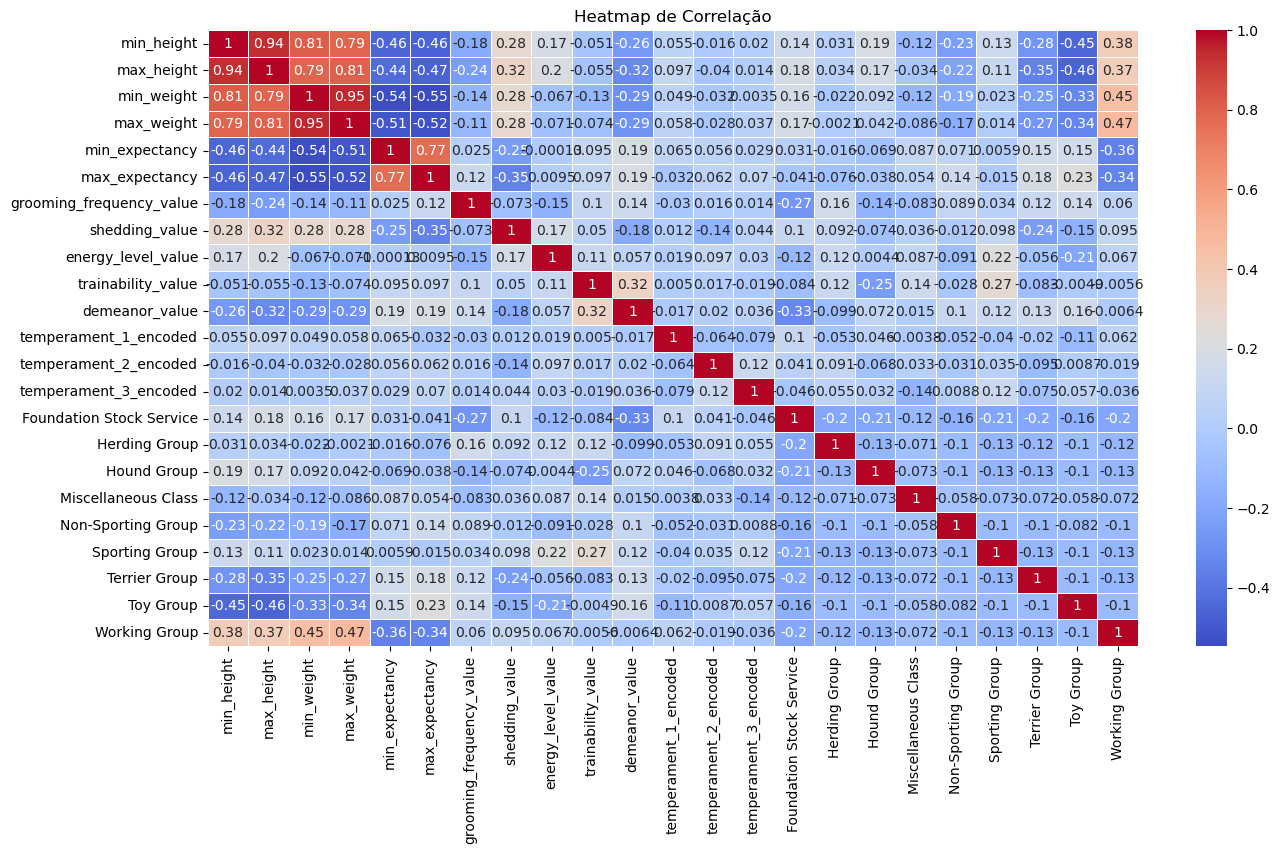

In [17]:
# Criar uma cópia do dataframe original
df_encoded = df.copy()

# Aplicar a codificação label encoding nas coluna de temperamento
label_encoder = LabelEncoder()
label_encoder.fit(temperament_values_sorted) # Ajustar o codificador com a lista de valores únicos
df_encoded['temperament_1_encoded'] = label_encoder.transform(df['temperament_1'])
df_encoded['temperament_2_encoded'] = label_encoder.transform(df['temperament_2'])
df_encoded['temperament_3_encoded'] = label_encoder.transform(df['temperament_3'])

# Aplicar a codificação one-hot encoding na coluna 'group'
df_encoded = pd.get_dummies(df_encoded, columns=['group'], prefix='', prefix_sep='')

# Calcular a matriz de correlação
correlation_matrix = df_encoded.corr()

# Plotar o heatmap de correlação
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de Correlação')
plt.show()

#### Gráfico de Barras por grupo canino 

O gráfico a seguir ajuda a ter uma noção da quantidade de cada grupo canino pelas suas qualidades de pelagem, treinamento, energia, comportamento e etc.  

C:\Users\saman\AppData\Local\Temp\ipykernel_25256\3318937178.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


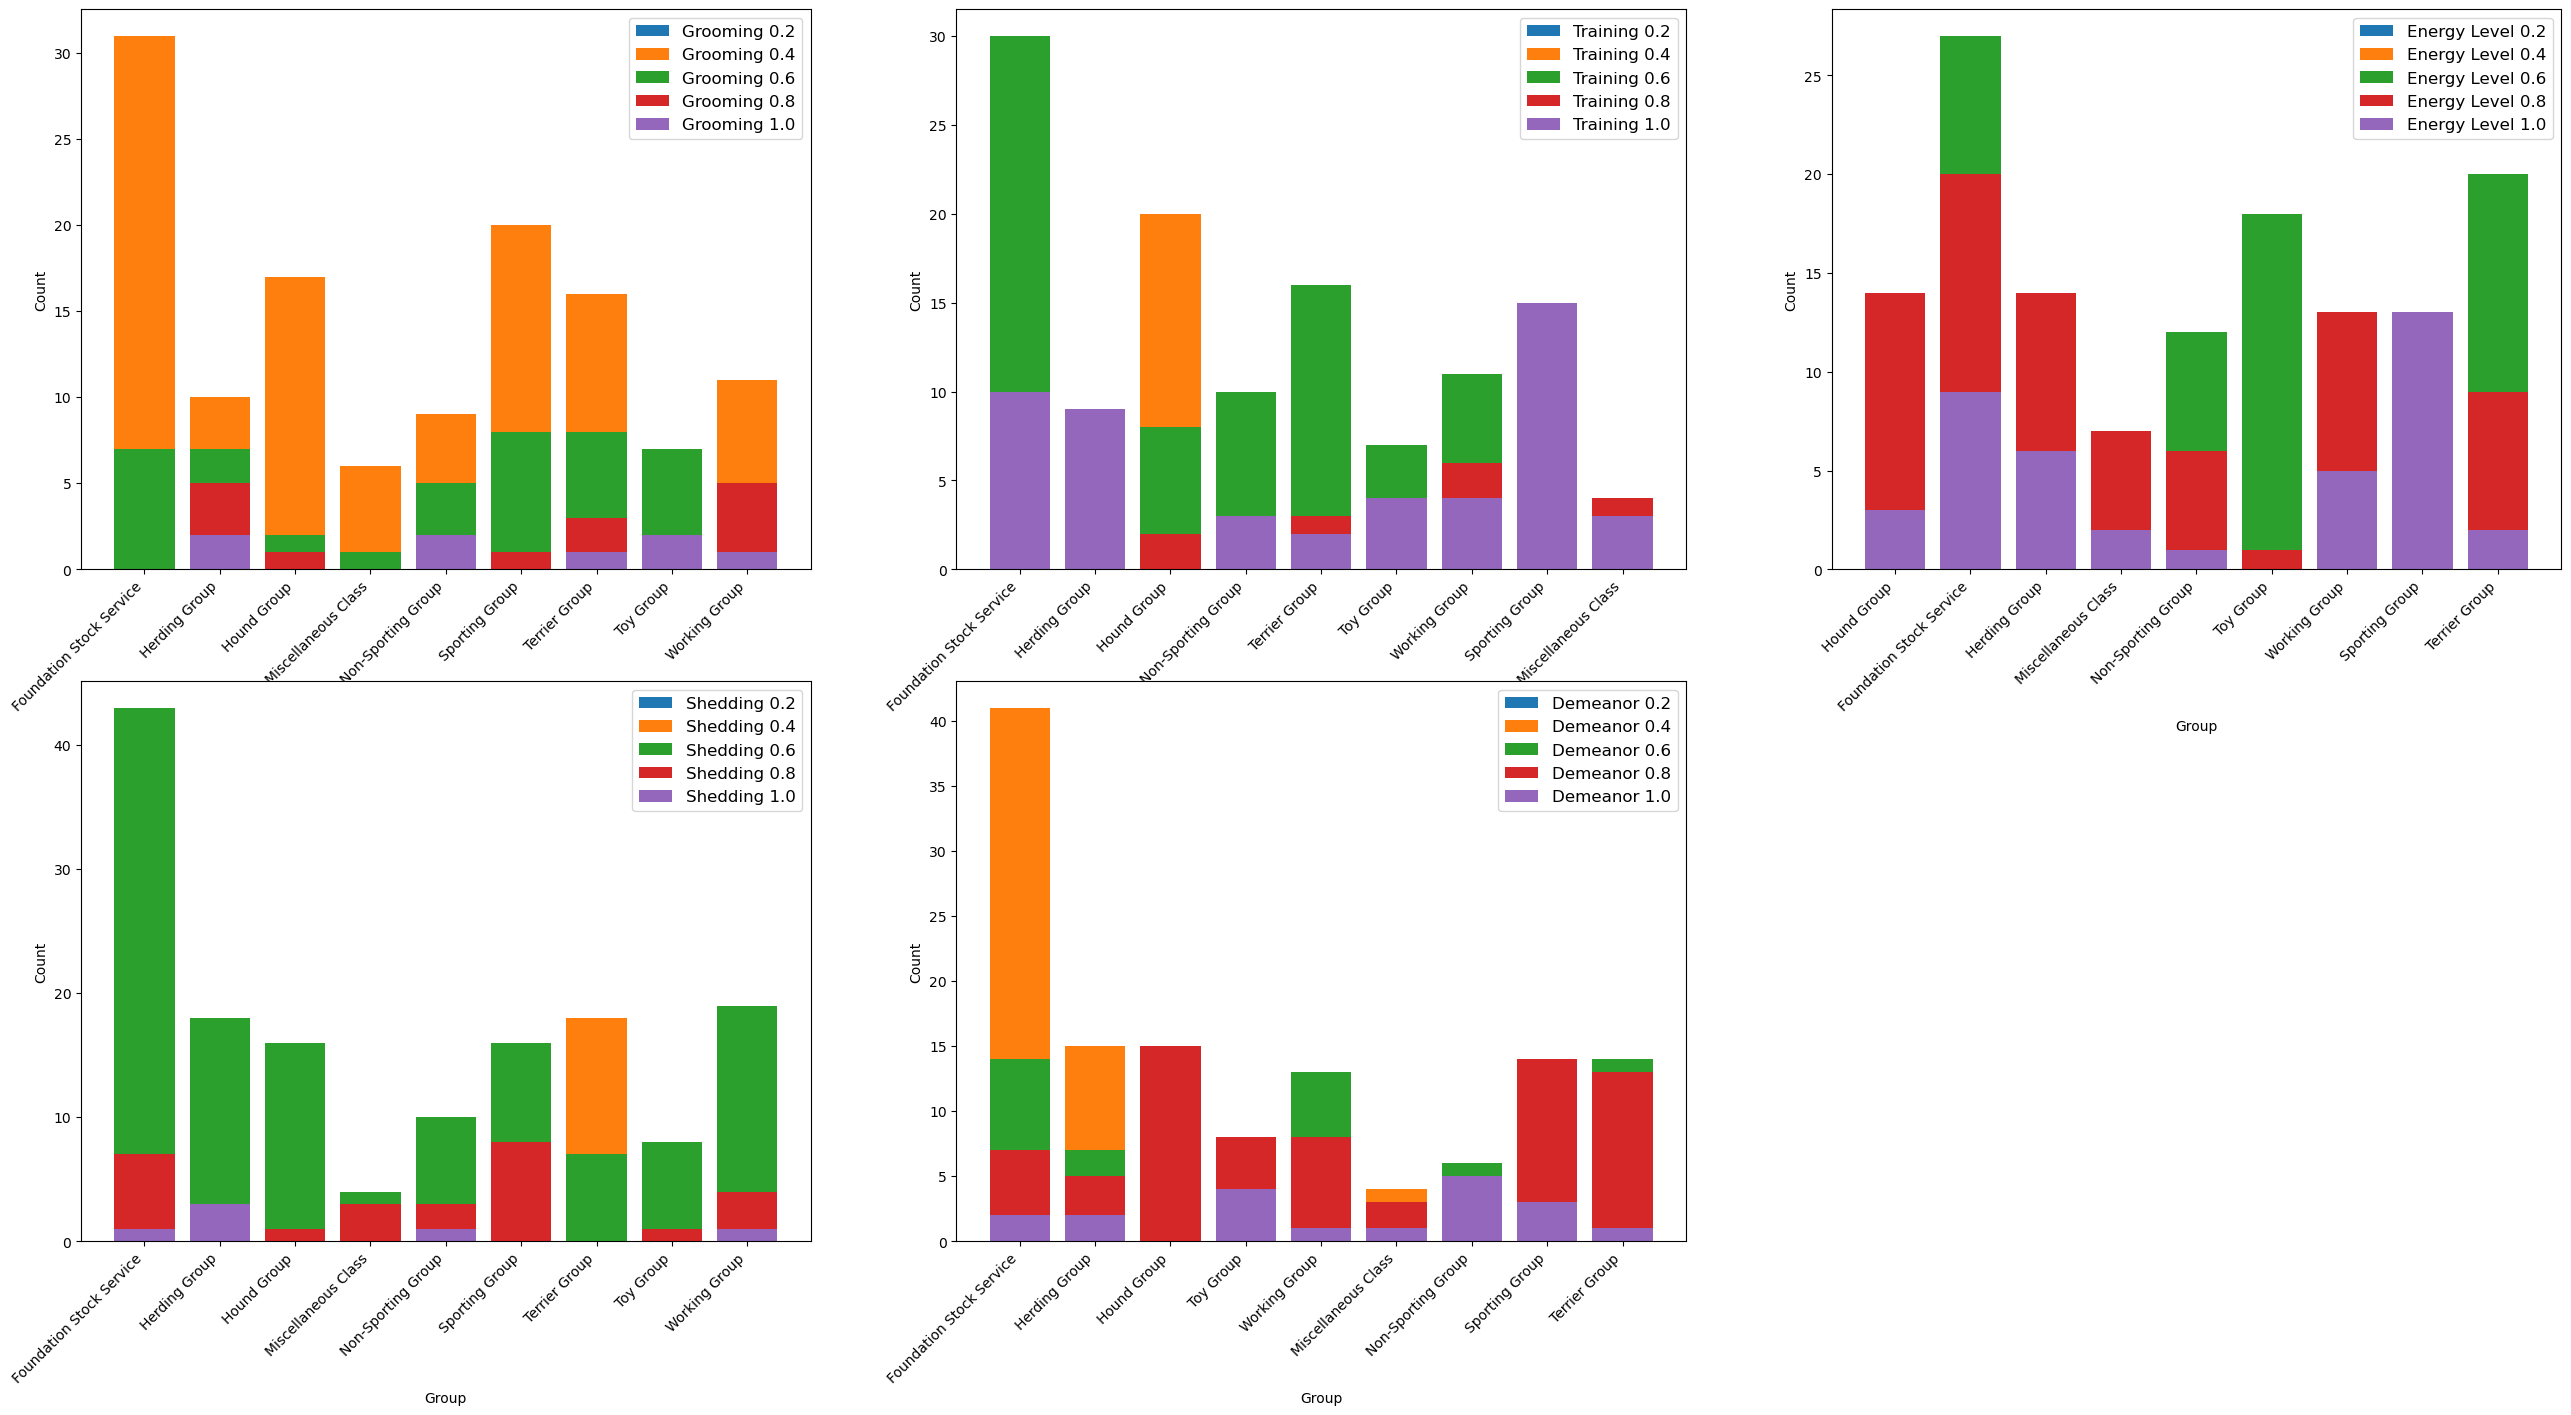

In [18]:
# Agrupando valores 
grooming_plt = df.groupby(['group', 'grooming_frequency_value']).size().reset_index(name='count')
training_plt = df.groupby(['group', 'trainability_value']).size().reset_index(name='count')
energy_plt = df.groupby(['group', 'energy_level_value']).size().reset_index(name='count')
shedding_plt = df.groupby(['group', 'shedding_value']).size().reset_index(name='count')
demeanor_plt = df.groupby(['group', 'demeanor_value']).size().reset_index(name='count')

# Definir a ordem dos valores únicos de grooming_frequency_value
df_values = [0.2, 0.4, 0.6, 0.8, 1.0]

# Criar o gráfico de barras
fig, axes = plt.subplots(2, 3, figsize=(32, 16))
for i, value in enumerate(df_values):
    subset = grooming_plt[grooming_plt['grooming_frequency_value'] == value]
    axes[0, 0].bar(subset['group'], subset['count'], label=f'Grooming {value}')

    subset = training_plt[training_plt['trainability_value'] == value]
    axes[0, 1].bar(subset['group'], subset['count'], label=f'Training {value}')

    subset = energy_plt[energy_plt['energy_level_value'] == value]
    axes[0, 2].bar(subset['group'], subset['count'], label=f'Energy Level {value}')

    subset = shedding_plt[shedding_plt['shedding_value'] == value]
    axes[1, 0].bar(subset['group'], subset['count'], label=f'Shedding {value}')

    subset = demeanor_plt[demeanor_plt['demeanor_value'] == value]
    axes[1, 1].bar(subset['group'], subset['count'], label=f'Demeanor {value}')

# Remover os subplots vazios
fig.delaxes(axes[1, 2])

# Configurar os eixos, títulos e legendas
for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('Group')
    ax.set_ylabel('Count')
    ax.legend(fontsize='large')

# Exibir a figura
plt.show()

#### Distribuição de cães por grupo e Gráfico de dispersão

Com base no gráfico de barras acima e a contagem de cães por grupo é desbalanceada, ou seja, há mais registro de cães de um determinado grupo que de outros. 

Aqui podemos observar que há uma grande quantidade de cães do grupo **Foundation Stock Service** (classe majoritária) enquanto que os demais grupos tem metade ou menos da metade presente na classe majoritária, este é o caso dos cães que se enquadram na classe **Miscellaneous** (classe minoritária).

> Realizar a técnica de _oversampling_ pode vir a ser necessária considerando a diferença de objetos por grupo.

Também decidi plotar um gráfico de dispersão para observar de outra forma a dispersão de cães por grupo com base no seu peso mínimo e máximo. Aqui poderemos observar que cães do grupo **Toy** e **Terrier** são os de menor porte se comparado ao dos grupos **Hound** e **Working**. Outros grupos caninos tem indivíduos que podem ser tanto de pequeno-médio à grande porte (caso dos cães do grupo **Herding** e **Foundation Stock Service**).

In [26]:
count_by_group = df['group'].value_counts()

# Exibe a contagem por grupo
print("GRUPO CANINO\t\t    qtd")
print("-"*32)
print(count_by_group)
print("-"*32)
print(f"Número total de cães:\t    {len(df)}")

GRUPO CANINO		    qtd
--------------------------------
Foundation Stock Service    68
Hound Group                 32
Sporting Group              32
Terrier Group               31
Working Group               31
Herding Group               30
Toy Group                   21
Non-Sporting Group          21
Miscellaneous Class         11
Name: group, dtype: int64
--------------------------------
Número total de cães:	    277


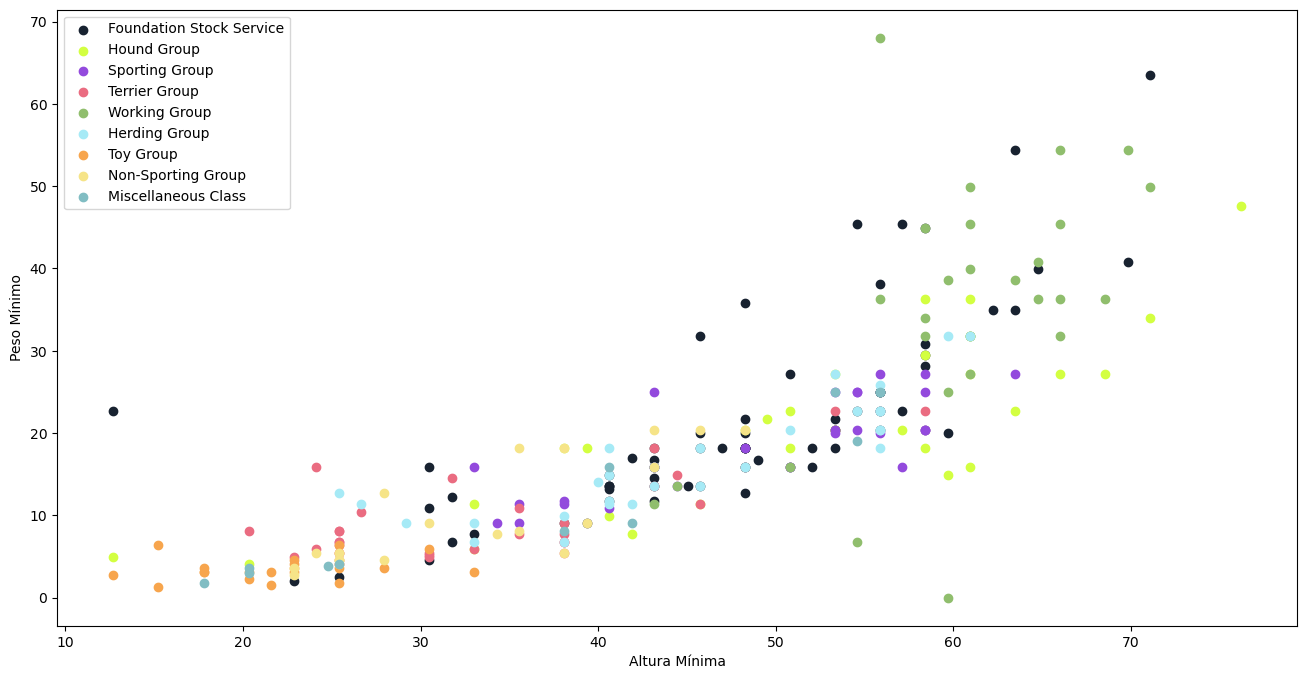

In [157]:
# Cria uma lista de cores para cada grupo de cão
cores = {
  'Foundation Stock Service': '#182230',
  'Hound Group': '#d3ff41',
  'Sporting Group': '#934add',
  'Terrier Group': '#ea6c81',
  'Working Group': '#90be6d',
  'Herding Group': '#a6eaf6',
  'Toy Group': '#f7a54d',
  'Non-Sporting Group': '#f6e488',
  'Miscellaneous Class': '#81bdc3'
}

# Cria uma figura e eixos para o gráfico
fig, ax = plt.subplots(figsize=(16, 8))

# Itera sobre cada grupo de cão
for grupo, cor in cores.items():
  # Filtra os dados apenas para o grupo de cão atual
  dados_grupo = df[df['group'] == grupo]
  
  # Plota o gráfico de dispersão para o grupo de cão atual
  ax.scatter(dados_grupo['min_height'], dados_grupo['min_weight'], color=cor, label=grupo)

# Define os rótulos dos eixos
ax.set_xlabel('Altura Mínima')
ax.set_ylabel('Peso Mínimo')

# Adiciona uma legenda
ax.legend()

# Exibe o gráfico de dispersão
plt.show()


## Questão 3
Defina um pipeline de redução de dimensionalidade, aplique e justifique sua escolha. Lembre de comparar a base reduzida com a original (ou mais próximo dela);

### Resolução
> O **PCA (Principal Component Analysis)** é uma técnica de redução utilizada para transformar um conjunto de variáveis correlacionadas (variáveis originais) em um novo conjunto de variáveis não correlacionadas (novos componentes principais) através de uma combinação linear. Assim, o PCA busca capturar a maior parte da variância dos dados em um menor número de dimensões.

Antes de realizar o redimensionamento, o dataframe possuia originalmente 14 colunas(15 se contarmos com a coluna de popularidade). A seguir foi utilizado o valor 9, mas o melhor valor de redução é aquele que melhor se aplica as métricas do modelo (acurácia, precisão e sensibilidade, vide questão 4).

A redução de dimensionalidade foi testada na questão 4 com diversos valores de `n_components` na aplicação do pipeline de redução. 

In [52]:
# realizando uma cópia do dataframe pré-processado
doggies = df.copy()

# Criar uma instância do LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(temperament_values_sorted) # Ajustar o codificador com a lista de valores únicos
doggies['temperament_1_encoded'] = label_encoder.transform(doggies['temperament_1'])
doggies['temperament_2_encoded'] = label_encoder.transform(doggies['temperament_2'])
doggies['temperament_3_encoded'] = label_encoder.transform(doggies['temperament_3'])

# del doggies['popularity']
del doggies['temperament_1']
del doggies['temperament_2']
del doggies['temperament_3']


doggies.head()

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,temperament_1_encoded,temperament_2_encoded,temperament_3_encoded
0,22.86,29.21,3.175147,4.535924,12.0,15.0,Toy Group,0.6,0.6,0.6,0.8,1.0,25,48,49
1,63.50,68.58,22.679619,27.215542,12.0,15.0,Hound Group,0.8,0.2,0.8,0.2,0.2,36,101,9
2,58.42,58.42,22.679619,31.751466,11.0,14.0,Terrier Group,0.6,0.4,0.6,1.0,0.8,50,23,27
3,60.96,71.12,31.751466,58.967008,10.0,13.0,Working Group,0.8,0.6,0.8,1.0,0.6,27,36,101
4,58.42,63.50,34.019428,38.555351,10.0,14.0,Working Group,0.6,0.6,0.8,0.4,0.8,3,78,93


In [107]:
# Definindo atributo de entrada e saída
x = doggies.drop('group', axis=1) # Remover a coluna original 'group'
x = RobustScaler().fit_transform(x)

# Criar uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Aplicar o label encoding à coluna 'group'
y = label_encoder.fit_transform(doggies['group'])

# Separando dados de treinamento (20% para testes e 80% para treinamento)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state = 1)

In [108]:
# Definir o pipeline k-NN
npca = 9
pipeline = Pipeline([
    ('scaling', StandardScaler()),  # Pré-processamento: normalização dos dados
    # ('feature_selection', SelectKBest(k=10)),  # Seleção das 10 melhores features
    ('dimensionality_reduction', PCA(n_components = npca)),  # Redução de dimensionalidade com PCA
])

x_train_df = pd.DataFrame(x_train)

# Aplicar o pipeline aos dados de treinamento
x_train_reduced = pipeline.fit_transform(x_train)
x_train_reduced_df = pd.DataFrame(x_train_reduced)

# Verificar as dimensões dos dados originais e reduzidos
print(">>> Dataframe original")
print("Dimensões dos dados originais:", x_train.shape)
print(x_train_df.head())
print()
print("-"*100)
print("\n>>> Dataframe reduzido")
print("Dimensões dos dados reduzidos:", x_train_reduced.shape)
print(x_train_reduced_df.head())

>>> Dataframe original
Dimensões dos dados originais: (221, 14)
         0         1        2         3    4    5    6    7    8    9    10  \
0  0.694444  0.545455  2.03125  1.630435 -2.5 -2.5 -0.5  0.0  1.0  0.0  0.0   
1  0.527778  0.500000  0.46875  0.217391  0.0  0.5 -0.5 -1.0  1.0 -0.5  1.0   
2  0.361111  0.545455  0.31250  0.543478 -0.5 -1.0  0.0  0.0  1.0  0.0  0.5   
3  0.583333  0.636364  0.93750  0.760870 -1.0  0.0 -0.5  0.0  0.0 -1.0 -0.5   
4  1.138889  1.000000  1.25000  1.195652 -2.0 -1.5 -0.5  0.0  0.0 -0.5  0.0   

         11        12        13  
0 -0.839286  0.265625 -0.794118  
1  0.000000  0.859375  1.029412  
2  1.178571 -0.406250  0.838235  
3 -0.803571 -0.234375  0.000000  
4  0.071429 -0.390625  0.426471  

----------------------------------------------------------------------------------------------------

>>> Dataframe reduzido
Dimensões dos dados reduzidos: (221, 9)
          0         1         2         3         4         5         6  \
0  4.359974 -0.1

In [57]:
# salvando em um novo arquivo .csv 

doggies.to_csv('dogs2.csv', index=False)

## Questão 4 (Supervisionado)
Defina um pipeline de aplicação de pelo menos 2 métodos de aprendizado de máquina supervisionado e da variação de ao menos 1 parâmetro deles, execute-o e justifique suas escolhas (sobre os métodos, parâmetros e valores);


### Resolução

#### Para o método k-NN

**Em relação ao treinamento utilizando o método **k-NN**** (sem oversampling)

A tabela a seguir apresenta o valor da acurácia (com e sem pipeline*) para cada valor de k utilizando o método k-NN. Dentre os valores obtidos, a melhor acurácia, sem a aplicação do pipeline de redução, foi para **`k = 1`** . Enquanto que a melhor acurácia, utilizando o pipeline de redução para `12` componentes, foi para **`k = 1`**.

| k-nn | Acurácia (s/ pipeline) |  Acurácia (PCA = 5) | Acurácia (PCA = 7) | Acurácia (PCA = 9) | Acurácia (PCA = 11) | Acurácia (PCA = 12) |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | <span style="background-color: yellow;">0.44643</span> | 0.33929 | 0.42857 | 0.42857 | 0.51786 | <span style="background-color: lime;">0.53571</span> |
| 3 | 0.39286 | 0.33929 | 0.33929 | 0.42857 | 0.35714 | 0.35714 |
| 5 | 0.35714 | 0.41071 | 0.37500 | 0.35714 | 0.39286 | 0.41071 |
| 7 | 0.41071 | 0.37500 | 0.30357 | 0.35714 | 0.46429 | 0.46429 |
| 9 | 0.35714 | 0.41071 | 0.37500 | 0.39286 | 0.48214 | 0.51786 |

**Em relação ao treinamento utilizando o método **k-NN**** (com oversampling)

A tabela a seguir apresenta o valor da acurácia (com e sem pipeline*) para cada valor de  utilizando o método k-NN. Dentre os valores obtidos, a melhor acurácia, sem a aplicação do pipeline de redução, foi também para **`k = 1`** . Enquanto que a melhor acurácia, utilizando o pipeline de redução para `12` componentes, também foi para **`k = 1`**.

| k-nn | Acurácia (s/ pipeline) |  Acurácia (PCA = 5) | Acurácia (PCA = 7) | Acurácia (PCA = 9) | Acurácia (PCA = 11) | Acurácia (PCA = 12) |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | <span style="background-color: yellow;">0.73171</span> | 0.70732 | 0.78049 | 0.85366 | 0.85366 | <span style="background-color: lime;">0.86179</span> |
| 3 | 0.61789 | 0.64228 | 0.61789 | 0.67480 | 0.70732 | 0.71545 |
| 5 | 0.56911 | 0.60976 | 0.53659 | 0.60163 | 0.60976 | 0.60163 |
| 7 | 0.52033 | 0.58537 | 0.55285 | 0.60163 | 0.54472 | 0.54472 |
| 9 | 0.50407 | 0.49593 | 0.47154 | 0.53659 | 0.54472 | 0.52033 |

#### Para o método Random Forest

**Em relação ao treinamento utilizando o método de Random Forest** (sem oversampling)

A tabela a seguir apresenta o valor da acurácia (com e sem pipeline*) para cada valor de `n_estimators` utilizando o método Random Forest. Dentre os valores obtidos, a melhor acurácia, sem a aplicação do pipeline de redução, foi para **`n_estimators = 100`**. Enquanto que a melhor acurácia, utilizando o pipeline de redução para `12` componentes, também foi para **`n_estimators = 100`**.

| n_estimators | Acurácia (s/ pipeline) | Acurácia (PCA = 5) | Acurácia (PCA = 7) | Acurácia (PCA = 9) | Acurácia (PCA = 11) | Acurácia (PCA = 12) |
| --- | --- | --- | --- | --- | --- | --- |
| 25 | 0.46429 | 0.39286 | 0.33929 | 0.42857 | 0.35714 | 0.42857 |
| 50 | 0.53571 | 0.35714 | 0.44643 | 0.44643 | 0.46429 | 0.41071 |
| 100 | <span style="background-color: yellow;">0.53571</span> | 0.33929 | 0.37500 | 0.41071 | 0.46429 | <span style="background-color: lime;">0.50000</span> |
| 125 | 0.46429 | 0.41071 | 0.46429 | 0.41071 | 0.44643 | 0.44643 |
| 150 | 0.50000 | 0.33929 | 0.37500 | 0.46429 | 0.51786 | 0.44643 |

**Em relação ao treinamento utilizando o método de Random Forest** (com oversampling)

A tabela a seguir apresenta o valor da acurácia (com e sem pipeline*) para cada valor de `n_estimators` utilizando o método Random Forest. Dentre os valores obtidos, a melhor acurácia, sem a aplicação do pipeline de redução, foi para **`n_estimators = 50`**. Enquanto que a melhor acurácia, utilizando o pipeline de redução para `12` componentes, foi para **`n_estimators = 100`**.

| n_estimators | Acurácia (s/ pipeline) | Acurácia (PCA = 5) | Acurácia (PCA = 7) | Acurácia (PCA = 9) | Acurácia (PCA = 11) | Acurácia (PCA = 12) |
| --- | --- | --- | --- | --- | --- | --- |
| 25 | 0.73984 | 0.62602 | 0.70732 | 0.73171 | 0.74797 | 0.78049 |
| 50 | <span style="background-color: yellow;">0.80488</span> | 0.65041 | 0.77236 | 0.74797 | 0.79675 | 0.82114 |
| 100 | 0.79675 | 0.68293 | 0.74797 | 0.78049 | 0.79675 | <span style="background-color: lime;">0.83740</span> |
| 125 | 0.80488 | 0.67480 | 0.74797 | 0.78862 | 0.75610 | 0.77236 |
| 150 | 0.80488 | 0.69919 | 0.73171 | 0.79675 | 0.78862 | 0.80488 |

#### Dados para Teste

In [94]:
# Os objetos de entrada são os 10 primeiros objetos da base de dados original (após o pré-processamento).

# Definir os dados de teste 
xd_test = np.array([
  [22.86,29.21,3.17514659,4.535923700000001,12.0,15.0,0.6,0.6,0.6,0.8,1.0,25,48,49], # Toy
  [63.5,68.58,22.6796185,27.2155422,12.0,15.0,0.8,0.2,0.8,0.2,0.2,36,101,9], # Hound
  [58.42,58.42,22.6796185,31.751465900000003,11.0,14.0,0.6,0.4,0.6,1.0,0.8,50,23,27], # Terrier
  [60.96,71.12,31.751465900000003,58.9670081,10.0,13.0,0.8,0.6,0.8,1.0,0.6,27,36,101], # Working
  [58.42,63.5,34.01942775,38.55535145,10.0,14.0,0.6,0.6,0.8,0.4,0.8,3,78,93], # Working
  [50.8,63.5,27.2155422,45.359237,10.0,12.0,0.2,0.6,0.8,0.6,0.6,78,112,131], # Foundation
  [58.42,66.04,20.41165665,29.48350405,11.0,12.0,0.2,0.4,0.8,0.6,0.6,123,80,117], # Hound
  [22.86,48.26,2.72155422,15.875732950000002,13.0,15.0,0.4,0.6,0.8,1.0,1.0,93,92,116], # Non-Sporting
  [53.34,63.5,27.2155422,31.751465900000003,11.0,13.0,0.2,0.6,0.8,0.4,0.8,66,40,125], # Hound
  [30.48,40.64,5.4431084400000005,7.25747792,14.0,16.0,0.4,0.4,0.6,0.6,0.6,41,5,29], # Terrier

  # Novos dados de teste, um cão de cada grupo
  [46.99,	58.42,	18.14,	24.95,	12,	14, 0.2,	0.6,	1,	0.6,	0.4,	50,	116,	139], # Foundation
  [33.02,	45.72,	9.07,	18.14,	12,	13,	0.8,	1,	0.8,	1,	0.8,	57,	69,	35], # Herding
  [71.12,	81.28,	34.02,	49.9,	8,	11,	0.2,	0.6,	0.6,	0.4,	0.6,	54,	36,	98], # Hound
  [25.4,	30.48,	4.08,	7.71,	12,	15,	0.2,	0.6,	0.8,	0.8,	0.8,	3,	133,	69], # Misc
  [25.4,	25.4,	4.08,	6.8,	12,	15,	0.4,	0.6,	0.4,	0.6,	0.6,	93,	16,	112], # Non-sporting
  [34.29, 39.37,	9.07,	13.61,	10,	14,	0.8,	0.4,	0.6,	1,	1,	54,	116,	61], # Sporting
  [25.4,	33.02,	6.35,	10.89,	12,	15,	0.4,	0.4,	0.6,	0.6,	0.4,	23,	2,	47], # Terrier
  [22.86,	25.4,	3.63,	6.35,	10,	12,	0.6,	0.6,	0.6,	0.4,	0.6,	54,	93,	69], # Toy
  [44.45,	49.53,	13.61,	22.68,	13,	16,	0.6,	0.2,	0.6,	0.4,	0.8,	49,	116,	118], # Working
  [55.88,	66.04,	22.68,	34.02,	12,	14,	0.6,	0.6,	0.6,	0.8,	0.8,	35,	59,	102] # Herding
])


#### Resultados
As tabelas a seguir são um comparativo entre as previsões realizadas pelos modelos que utilizam o método k-NN e o método Random Forest, tanto com ou sem a aplicação do pipeline de redução, como também com ou sem a aplicação de _oversampling_ na base de dados. 

Os dados de testes utilizados são extras e pertencem a lista `xd_test`, da célula de código anterior, e ela contém 20 entradas.

> Também é possível comparar as previsões pelas matrizes de confusão para cada modelo e para cada uma das situações (com ou sem pipeline, com ou sem _oversampling_).

Com base no teste realizado e registrado aqui, podemos observar que o método Random Forest classificou corretamente um cachorro a mais que o método k-NN, onde ambos estavam com _oversampling_ e com a aplicação do pipeline de redução.

**Método k-NN**

Após aplicar _oversampling_, obtivemos uma melhora nos acertos das previsões, pois diminuimos a tendência do modelo 'optar por prever' um grupo específico. Se formos observar os resultados **_sem oversamling_** (independente de não ter ou ter aplicado o pipeline de redução), podemos observar que o modelo tinha uma tendência de classficar a maioria dos cães como pertencente do grupo Foundation Stock Service (classe majoritária). 

Caso contrário, ele _previa_ que aquele objeto seria do grupo _Hound_ ou _Working_ (outros dois grupos mais populosos depois de Foundation Stock Service).

| # | Grupo Verdadeiro | s/ pipeline s/ oversampling | c/ pipeline s/ oversampling | s/ pipeline c/ oversampling | c/ pipeline c/ oversampling |
|---| --- | --- | --- | --- | --- |
| 1 | Toy          |x|x|✅|✅
| 2 | Hound        |x|x|✅|✅|
| 3 | Terrier      |x|x|x|✅|
| 4 | Working      |x|x|✅|✅|
| 5 | Working      |x|x|✅|✅|
| 6 | Foundation   |✅|✅|✅|✅|
| 7 | Hound        |x|✅|✅|✅|
| 8 | Non-sporting |x|x|✅|✅|
| 9 | Hound        |x|x|✅|✅|
| 10 | Terrier     |x|x|✅|✅|
| 11 | Foundation  |✅|✅|x|x|
| 12 | Herding     |x|x|x|✅|
| 13 | Hound       |x|x|✅|✅|
| 14 | Misc        |x|x|✅|✅|
| 15 | Non-sporting|x|x|✅|✅|
| 16 | Sporting    |x|x|✅|✅|
| 17 | Terrier     |x|x|✅|✅|
| 18 | Toy         |x|x|✅|✅|
| 19 | Working     |x|x|✅|✅|
| 20 | Herding     |x|x|x |x |

**Método Random Forest**

| # | Grupo Verdadeiro | s/ pipeline s/ oversampling | c/ pipeline s/ oversampling | s/ pipeline c/ oversampling | c/ pipeline c/ oversampling |
|---| --- | --- | --- | --- | --- |
| 1 | Toy            |x|x|✅|✅|
| 2 | Hound          |x|x|✅|✅|
| 3 | Terrier        |x|x|x|x|
| 4 | Working        |✅|x|✅|✅|
| 5 | Working        |✅|x|✅|✅|
| 6 | Foundation     |x|✅|✅|✅|
| 7 | Hound          |x|x|x|✅|
| 8 | Non-sporting   |x|x|✅|✅|
| 9 | Hound          |x|✅|✅|✅|
| 10 | Terrier       |x|x|✅|✅|
| 11 | Foundation    |x|✅|x|✅|
| 12 | Herding       |x|x|✅|✅|
| 13 | Hound         |x|x|✅|✅|
| 14 | Misc          |x|x|✅|✅|
| 15 | Non-sporting  |x|x|✅|✅|
| 16 | Sporting      |x|x|✅|✅|
| 17 | Terrier       |x|x|✅|✅|
| 18 | Toy           |x|x|✅|✅|
| 19 | Working       |✅|x|✅|✅|
| 20 | Herding       |x|x|✅|✅|

#### Método k-NN
> **Sobre o método k-NN**:é um algoritmo é amplamente utilizado em problemas de reconhecimento de padrões, classificação de imagens, reconhecimento de caracteres manuscritos, processamento de fala e análise de dados biomédicos, entre outros. Este algoritmo utiliza os exemplos de treinamento k mais próximos ao exemplo de teste para realizar predições. 

* Atributo alvo: `group`
* KNN, k = {1, 3, 5, 7, 9}
* E para cada valor de k, foi calculada a:
  * Acurácia, 
  * Precisão,
  * e Sensibilidade do modelo

> Acurácia: mede, de maneira geral, a frequência que o classificador está correto. 

> Precisão: mede a incidência do modelo prever o grupo de um determinado cão, assim definindo o quão correta foi a precisão

> Sensibilidade: mede a capacidade do modelo identificar corretamente os casos positivos.

##### Treinamento s/ Oversamplig

In [106]:
k_values = [1, 3, 5, 7, 9]
npca_list = [5, 7, 9, 11, 12]

print("SEM OVERSAMPLING")
print("-"*32)
for k in k_values:
  # Sem o pipeline
  knn_classifier = KNeighborsClassifier(n_neighbors=k)
  knn_classifier.fit(x_train, y_train)
  y_pred = knn_classifier.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  confusionm = confusion_matrix(y_test, y_pred)
  print("Sem pipeline")
  print(f"k = {k}: Acurácia = {accuracy:.5f}")
  print(f"k = {k}: Precisão = {precision:.5f}")
  print(f"k = {k}: Sensibilidade = {recall:.5f}")
  print(f'Matriz de Confusão: \n {confusionm}\n')


  # Com o pipeline
  for i in npca_list: 

    pipeline = Pipeline([
      ('scaling', StandardScaler()),
      ('dimensionality_reduction', PCA(n_components=i)),
      ('classification', KNeighborsClassifier(n_neighbors=k))
    ])
    pipeline.fit(x_train, y_train)
    x_test_reduced = pipeline['dimensionality_reduction'].transform(x_test)
    y_pred = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    confusionm = confusion_matrix(y_test, y_pred)
    print(f"Com pipeline, n_components PCA = {i}")
    print(f"k = {k}: Acurácia = {accuracy:.5f}")
    print(f"k = {k}: Precisão = {precision:.5f}")
    print(f"k = {k}: Sensibilidade = {recall:.5f}")
    print(f'Matriz de Confusão: \n {confusionm}\n')

  print("-"*100)


SEM OVERSAMPLING
--------------------------------
Sem pipeline
k = 1: Acurácia = 0.68293
k = 1: Precisão = 0.67932
k = 1: Sensibilidade = 0.69425
Matriz de Confusão: 
 [[ 5  2  2  1  0  3  2  0  2]
 [ 1  5  4  0  0  0  2  0  0]
 [ 0  1  6  0  0  0  0  1  0]
 [ 1  1  0 11  0  0  2  0  0]
 [ 1  0  1  0 11  1  0  0  0]
 [ 0  2  1  1  1 11  0  0  0]
 [ 0  0  3  1  1  0 12  0  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 1  0  0  0  0  0  0  0  7]]

Com pipeline, n_components PCA = 5
k = 1: Acurácia = 0.68293
k = 1: Precisão = 0.66978
k = 1: Sensibilidade = 0.67836
Matriz de Confusão: 
 [[ 4  1  3  1  4  2  0  0  2]
 [ 1  5  4  0  0  1  0  0  1]
 [ 0  0  7  0  0  0  1  0  0]
 [ 0  1  0 14  0  0  0  0  0]
 [ 1  0  3  0  8  0  1  0  1]
 [ 2  0  1  1  0 12  0  0  0]
 [ 1  0  1  0  0  0 14  1  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 1  0  1  0  0  2  0  0  4]]

Com pipeline, n_components PCA = 7
k = 1: Acurácia = 0.76423
k = 1: Precisão = 0.77635
k = 1: Sensibilidade = 0.75607
Matriz de Confusão: 
 [[11  0 

c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: 

Com pipeline, n_components PCA = 12
k = 3: Acurácia = 0.69106
k = 3: Precisão = 0.70931
k = 3: Sensibilidade = 0.69271
Matriz de Confusão: 
 [[ 8  1  2  4  0  2  0  0  0]
 [ 0  8  2  1  1  0  0  0  0]
 [ 0  0  6  0  0  0  1  0  1]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  1  0  3  8  0  1  1  0]
 [ 1  3  1  2  0  9  0  0  0]
 [ 1  1  3  0  2  0 10  0  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 1  0  1  0  0  1  0  0  5]]

----------------------------------------------------------------------------------------------------
Sem pipeline
k = 5: Acurácia = 0.52846
k = 5: Precisão = 0.52095
k = 5: Sensibilidade = 0.54441
Matriz de Confusão: 
 [[ 2  2  2  1  2  5  1  0  2]
 [ 1  7  2  0  1  0  1  0  0]
 [ 1  1  5  0  0  0  0  1  0]
 [ 2  1  0  9  1  2  0  0  0]
 [ 1  0  0  1  9  1  1  1  0]
 [ 1  2  5  2  0  4  1  0  1]
 [ 2  0  2  0  1  0 12  0  0]
 [ 0  1  0  1  1  0  1 12  0]
 [ 0  2  0  0  0  1  0  0  5]]

Com pipeline, n_components PCA = 5
k = 5: Acurácia = 0.51220
k = 5: Precisão = 0.54265
k = 5: Se

c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: 

Com pipeline, n_components PCA = 5
k = 9: Acurácia = 0.49593
k = 9: Precisão = 0.51857
k = 9: Sensibilidade = 0.47968
Matriz de Confusão: 
 [[ 3  3  7  1  1  2  0  0  0]
 [ 1  4  4  2  0  1  0  0  0]
 [ 0  3  3  0  0  0  1  0  1]
 [ 0  1  0 14  0  0  0  0  0]
 [ 1  0  3  1  4  0  2  3  0]
 [ 2  1  2  2  2  6  1  0  0]
 [ 1  1  2  0  1  0 10  2  0]
 [ 0  0  0  0  2  0  0 14  0]
 [ 1  0  3  0  0  1  0  0  3]]

Com pipeline, n_components PCA = 7
k = 9: Acurácia = 0.54472
k = 9: Precisão = 0.56768
k = 9: Sensibilidade = 0.52516
Matriz de Confusão: 
 [[ 7  1  3  1  2  2  0  1  0]
 [ 2  6  4  0  0  0  0  0  0]
 [ 0  1  3  0  1  0  2  0  1]
 [ 0  0  1 14  0  0  0  0  0]
 [ 1  1  2  1  4  0  3  2  0]
 [ 1  2  1  1  1 10  0  0  0]
 [ 2  1  2  0  2  0  8  2  0]
 [ 0  1  0  0  0  0  3 12  0]
 [ 0  2  3  0  0  0  0  0  3]]

Com pipeline, n_components PCA = 9
k = 9: Acurácia = 0.58537
k = 9: Precisão = 0.59536
k = 9: Sensibilidade = 0.57985
Matriz de Confusão: 
 [[ 6  0  3  3  2  3  0  0  0]
 [ 0  

c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


##### Teste s/ pipeline, s/ oversampling

In [99]:
print("k-NN, Testando sem pipeline")

# Fazer previsões com o modelo k-NN
k = 1 # Escolha o valor de k desejado
knn_classifier = KNeighborsClassifier(n_neighbors=9)
knn_classifier.fit(x_train, y_train)
predictions = knn_classifier.predict(xd_test)
print(predictions)

predicted_groups = label_encoder.inverse_transform(predictions)
print(predicted_groups)


k-NN, Testando sem pipeline
[0 0 8 0 0 0 0 0 0 8 0 8 8 0 0 0 0 0 0 0]
['Foundation Stock Service' 'Foundation Stock Service' 'Working Group'
 'Foundation Stock Service' 'Foundation Stock Service'
 'Foundation Stock Service' 'Foundation Stock Service'
 'Foundation Stock Service' 'Foundation Stock Service' 'Working Group'
 'Foundation Stock Service' 'Working Group' 'Working Group'
 'Foundation Stock Service' 'Foundation Stock Service'
 'Foundation Stock Service' 'Foundation Stock Service'
 'Foundation Stock Service' 'Foundation Stock Service'
 'Foundation Stock Service']


##### Teste c/ pipeline, s/ oversampling

In [100]:
# Definir o pipeline
npca = 12
k = 1

# Ajustar o scaler nos dados de treinamento
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Reduzir a dimensionalidade nos dados de treinamento
pca = PCA(n_components=npca)
x_train_reduced = pca.fit_transform(x_train_scaled)

# Criar o classificador KNN
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Treinar o classificador com os dados reduzidos
knn_classifier.fit(x_train_reduced, y_train)

# Aplicar o scaler e a redução de dimensionalidade nos dados de teste
x_test_scaled = scaler.transform(xd_test)
x_test_reduced = pca.transform(x_test_scaled)

# Fazer previsões com o classificador
y_pred = knn_classifier.predict(x_test_reduced)

# Imprimir as previsões
print("k-NN, Testando com pipeline")
print(y_pred)

# Converter as previsões de volta para os rótulos originais
predicted_groups = label_encoder.inverse_transform(y_pred)
print(predicted_groups)



k-NN, Testando com pipeline
[0 8 8 0 0 0 2 1 8 2 0 2 8 1 2 1 8 1 0 0]
['Foundation Stock Service' 'Working Group' 'Working Group'
 'Foundation Stock Service' 'Foundation Stock Service'
 'Foundation Stock Service' 'Hound Group' 'Herding Group' 'Working Group'
 'Hound Group' 'Foundation Stock Service' 'Hound Group' 'Working Group'
 'Herding Group' 'Hound Group' 'Herding Group' 'Working Group'
 'Herding Group' 'Foundation Stock Service' 'Foundation Stock Service']


##### Treinamento c/ Oversampling

In [101]:
from imblearn.over_sampling import SMOTE

# Realizando oversampling devido a diferença entre a quantidade de cães por grupo canino
dcp = doggies.copy()

# Separa as colunas de features e o alvo
x = dcp.drop('group', axis=1)
y = dcp['group']

# Aplica o SMOTE para gerar dados sintéticos
smote = SMOTE()
x_oversampled, y_oversampled = smote.fit_resample(x, y)

# Cria um novo DataFrame com as features e o alvo oversampled
dados_oversampled = pd.DataFrame(x_oversampled, columns=x.columns)
dados_oversampled['group'] = y_oversampled

count_by_group_oversampled = dados_oversampled['group'].value_counts()

# Verifica o novo número de objetos após o oversampling
num_objetos_oversampled = len(dados_oversampled)

count_by_group = dcp['group'].value_counts()

# Exibe a contagem por grupo
print("GRUPO CANINO\t\t    qtd")
print("-"*32)
print(count_by_group_oversampled)
print("-"*32)
print("Número total de cães após oversampling:", num_objetos_oversampled)

GRUPO CANINO		    qtd
--------------------------------
Toy Group                   68
Hound Group                 68
Terrier Group               68
Working Group               68
Foundation Stock Service    68
Non-Sporting Group          68
Sporting Group              68
Herding Group               68
Miscellaneous Class         68
Name: group, dtype: int64
--------------------------------
Número total de cães após oversampling: 612


In [102]:
# Criar uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Aplicar o label encoding à coluna 'group' em dados_oversampled
dados_oversampled['group'] = label_encoder.fit_transform(dados_oversampled['group'])

# Separando dados de treinamento e testes
x_train, x_test, y_train, y_test = train_test_split(dados_oversampled.drop('group', axis=1), dados_oversampled['group'], test_size=0.2, random_state=42)

k_values = [1, 3, 5, 7, 9]
npca_list = [5, 7, 9, 11, 12]


print("COM OVERSAMLING")
print("-"*32)
for k in k_values:
  # Sem o pipeline
  knn_classifier = KNeighborsClassifier(n_neighbors=k)
  knn_classifier.fit(x_train, y_train)
  y_pred = knn_classifier.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  confusionm = confusion_matrix(y_test, y_pred)
  print("Sem pipeline")
  print(f"k = {k}: Acurácia = {accuracy:.5f}")
  print(f"k = {k}: Precisão = {precision:.5f}")
  print(f"k = {k}: Sensibilidade = {recall:.5f}")
  print(f'Matriz de Confusão:\n{confusionm}\n')

  # Com o pipeline
  for i in npca_list:
    pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ('dimensionality_reduction', PCA(n_components=i)),
        ('classification', KNeighborsClassifier(n_neighbors=k))
    ])
    pipeline.fit(x_train, y_train)
    X_test_reduced = pipeline['dimensionality_reduction'].transform(x_test)
    y_pred = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    confusionm = confusion_matrix(y_test, y_pred)
    print(f"Com pipeline, n_components PCA = {i}")
    print(f"k = {k}: Acurácia = {accuracy:.5f}")
    print(f"k = {k}: Precisão = {precision:.5f}")
    print(f"k = {k}: Sensibilidade = {recall:.5f}")
    print(f'Matriz de Confusão:\n{confusionm}\n')

  print("-" * 100)


COM OVERSAMLING
--------------------------------
Sem pipeline
k = 1: Acurácia = 0.68293
k = 1: Precisão = 0.67932
k = 1: Sensibilidade = 0.69425
Matriz de Confusão:
[[ 5  2  2  1  0  3  2  0  2]
 [ 1  5  4  0  0  0  2  0  0]
 [ 0  1  6  0  0  0  0  1  0]
 [ 1  1  0 11  0  0  2  0  0]
 [ 1  0  1  0 11  1  0  0  0]
 [ 0  2  1  1  1 11  0  0  0]
 [ 0  0  3  1  1  0 12  0  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 1  0  0  0  0  0  0  0  7]]

Com pipeline, n_components PCA = 5
k = 1: Acurácia = 0.68293
k = 1: Precisão = 0.66978
k = 1: Sensibilidade = 0.67836
Matriz de Confusão:
[[ 4  1  3  1  4  2  0  0  2]
 [ 1  5  4  0  0  1  0  0  1]
 [ 0  0  7  0  0  0  1  0  0]
 [ 0  1  0 14  0  0  0  0  0]
 [ 1  0  3  0  8  0  1  0  1]
 [ 2  0  1  1  0 12  0  0  0]
 [ 1  0  1  0  0  0 14  1  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 1  0  1  0  0  2  0  0  4]]

Com pipeline, n_components PCA = 7
k = 1: Acurácia = 0.76423
k = 1: Precisão = 0.77635
k = 1: Sensibilidade = 0.75607
Matriz de Confusão:
[[11  0  1  2  

c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Sem pipeline
k = 3: Acurácia = 0.57724
k = 3: Precisão = 0.55163
k = 3: Sensibilidade = 0.56582
Matriz de Confusão:
[[ 5  1  1  1  2  4  1  0  2]
 [ 1  7  1  0  2  0  1  0  0]
 [ 1  1  6  0  0  0  0  0  0]
 [ 1  0  0 12  0  0  2  0  0]
 [ 1  0  1  0  9  1  1  1  0]
 [ 2  2  2  2  0  7  0  0  1]
 [ 2  0  3  0  1  0 11  0  0]
 [ 0  1  0  1  0  0  1 13  0]
 [ 3  3  0  0  0  1  0  0  1]]

Com pipeline, n_components PCA = 5
k = 3: Acurácia = 0.60976
k = 3: Precisão = 0.65368
k = 3: Sensibilidade = 0.60828
Matriz de Confusão:
[[ 6  2  5  1  2  1  0  0  0]
 [ 1  8  2  0  0  1  0  0  0]
 [ 0  1  5  0  0  0  1  0  1]
 [ 0  2  0 13  0  0  0  0  0]
 [ 1  0  2  1  7  0  1  2  0]
 [ 2  0  3  0  2  8  1  0  0]
 [ 2  0  3  0  1  0 10  1  0]
 [ 0  0  1  0  1  0  0 14  0]
 [ 1  0  3  0  0  0  0  0  4]]

Com pipeline, n_components PCA = 7
k = 3: Acurácia = 0.64228
k = 3: Precisão = 0.65794
k = 3: Sensibilidade = 0.62922
Matriz de Confusão:
[[ 9  2  1  4  1  0  0  0  0]
 [ 3  5  3  0  0  1  0  0  0]
 [ 0

c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Sem pipeline
k = 5: Acurácia = 0.52846
k = 5: Precisão = 0.52095
k = 5: Sensibilidade = 0.54441
Matriz de Confusão:
[[ 2  2  2  1  2  5  1  0  2]
 [ 1  7  2  0  1  0  1  0  0]
 [ 1  1  5  0  0  0  0  1  0]
 [ 2  1  0  9  1  2  0  0  0]
 [ 1  0  0  1  9  1  1  1  0]
 [ 1  2  5  2  0  4  1  0  1]
 [ 2  0  2  0  1  0 12  0  0]
 [ 0  1  0  1  1  0  1 12  0]
 [ 0  2  0  0  0  1  0  0  5]]

Com pipeline, n_components PCA = 5
k = 5: Acurácia = 0.51220
k = 5: Precisão = 0.54265
k = 5: Sensibilidade = 0.50354
Matriz de Confusão:
[[ 4  2  7  1  1  2  0  0  0]
 [ 1  5  3  1  0  2  0  0  0]
 [ 0  0  4  0  0  0  1  1  2]
 [ 1  4  0 10  0  0  0  0  0]
 [ 0  1  2  0  7  0  2  2  0]
 [ 1  1  3  0  2  8  1  0  0]
 [ 2  0  2  1  1  0 10  1  0]
 [ 0  0  0  0  4  0  0 12  0]
 [ 0  1  3  0  0  1  0  0  3]]

Com pipeline, n_components PCA = 7
k = 5: Acurácia = 0.58537
k = 5: Precisão = 0.58317
k = 5: Sensibilidade = 0.56939
Matriz de Confusão:
[[ 6  0  4  3  2  1  0  1  0]
 [ 3  3  2  1  1  1  0  0  1]
 [ 0

c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: 

Com pipeline, n_components PCA = 5
k = 7: Acurácia = 0.47154
k = 7: Precisão = 0.48318
k = 7: Sensibilidade = 0.45051
Matriz de Confusão:
[[ 4  2  6  1  1  3  0  0  0]
 [ 2  4  3  2  0  1  0  0  0]
 [ 0  1  3  0  0  0  2  0  2]
 [ 2  2  0 11  0  0  0  0  0]
 [ 1  1  2  0  4  0  3  3  0]
 [ 1  1  3  1  1  8  1  0  0]
 [ 2  1  2  1  1  0  9  1  0]
 [ 0  0  0  0  3  0  0 13  0]
 [ 1  2  3  0  0  0  0  0  2]]

Com pipeline, n_components PCA = 7
k = 7: Acurácia = 0.53659
k = 7: Precisão = 0.56425
k = 7: Sensibilidade = 0.52453
Matriz de Confusão:
[[ 4  1  6  1  4  0  1  0  0]
 [ 1  8  2  0  1  0  0  0  0]
 [ 0  0  4  0  1  0  2  0  1]
 [ 0  0  0 15  0  0  0  0  0]
 [ 1  1  2  2  4  0  2  2  0]
 [ 2  2  1  1  1  9  0  0  0]
 [ 2  2  2  0  1  0  8  2  0]
 [ 0  1  0  0  1  0  2 12  0]
 [ 0  2  3  1  0  0  0  0  2]]

Com pipeline, n_components PCA = 9
k = 7: Acurácia = 0.57724
k = 7: Precisão = 0.59613
k = 7: Sensibilidade = 0.56186
Matriz de Confusão:
[[ 5  2  4  1  3  2  0  0  0]
 [ 0  6  2  

c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_components PCA = 5
k = 9: Acurácia = 0.49593
k = 9: Precisão = 0.51857
k = 9: Sensibilidade = 0.47968
Matriz de Confusão:
[[ 3  3  7  1  1  2  0  0  0]
 [ 1  4  4  2  0  1  0  0  0]
 [ 0  3  3  0  0  0  1  0  1]
 [ 0  1  0 14  0  0  0  0  0]
 [ 1  0  3  1  4  0  2  3  0]
 [ 2  1  2  2  2  6  1  0  0]
 [ 1  1  2  0  1  0 10  2  0]
 [ 0  0  0  0  2  0  0 14  0]
 [ 1  0  3  0  0  1  0  0  3]]

Com pipeline, n_components PCA = 7
k = 9: Acurácia = 0.54472
k = 9: Precisão = 0.56768
k = 9: Sensibilidade = 0.52516
Matriz de Confusão:
[[ 7  1  3  1  2  2  0  1  0]
 [ 2  6  4  0  0  0  0  0  0]
 [ 0  1  3  0  1  0  2  0  1]
 [ 0  0  1 14  0  0  0  0  0]
 [ 1  1  2  1  4  0  3  2  0]
 [ 1  2  1  1  1 10  0  0  0]
 [ 2  1  2  0  2  0  8  2  0]
 [ 0  1  0  0  0  0  3 12  0]
 [ 0  2  3  0  0  0  0  0  3]]

Com pipeline, n_components PCA = 9
k = 9: Acurácia = 0.58537
k = 9: Precisão = 0.59536
k = 9: Sensibilidade = 0.57985
Matriz de Confusão:
[[ 6  0  3  3  2  3  0  0  0]
 [ 0  5  3  

c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


##### Teste s/ pipeline, c/ oversampling

In [103]:
print("Testando sem pipeline de redução")

# Fazer previsões com o modelo k-NN
k = 1 # Escolha o valor de k desejado
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(x_train, y_train)
predictions = knn_classifier.predict(xd_test)
print(predictions)

predicted_groups = label_encoder.inverse_transform(predictions)
print(predicted_groups)


Testando sem pipeline de redução
[7 2 2 8 8 0 2 4 2 6 5 6 2 3 4 5 6 7 8 2]
['Toy Group' 'Hound Group' 'Hound Group' 'Working Group' 'Working Group'
 'Foundation Stock Service' 'Hound Group' 'Non-Sporting Group'
 'Hound Group' 'Terrier Group' 'Sporting Group' 'Terrier Group'
 'Hound Group' 'Miscellaneous Class' 'Non-Sporting Group' 'Sporting Group'
 'Terrier Group' 'Toy Group' 'Working Group' 'Hound Group']


c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


##### Teste c/ pipeline, c/ oversampling

In [104]:
print("Testando com pipeline de redução")

# Definir o pipeline
npca = 12
k = 1

# Ajustar o scaler nos dados de treinamento
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Reduzir a dimensionalidade nos dados de treinamento
pca = PCA(n_components=npca)
x_train_reduced = pca.fit_transform(x_train_scaled)

# Criar o classificador KNN
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Treinar o classificador com os dados reduzidos
knn_classifier.fit(x_train_reduced, y_train)

# Aplicar o scaler e a redução de dimensionalidade nos dados de teste
x_test_scaled = scaler.transform(xd_test)
x_test_reduced = pca.transform(x_test_scaled)

# Fazer previsões com o classificador
y_pred = knn_classifier.predict(x_test_reduced)

# Imprimir as previsões
print(y_pred)

# Converter as previsões de volta para os rótulos originais
predicted_groups = label_encoder.inverse_transform(y_pred)
print(predicted_groups)


Testando com pipeline de redução
[7 2 6 8 8 0 2 4 2 6 5 1 2 3 4 5 6 7 8 5]
['Toy Group' 'Hound Group' 'Terrier Group' 'Working Group' 'Working Group'
 'Foundation Stock Service' 'Hound Group' 'Non-Sporting Group'
 'Hound Group' 'Terrier Group' 'Sporting Group' 'Herding Group'
 'Hound Group' 'Miscellaneous Class' 'Non-Sporting Group' 'Sporting Group'
 'Terrier Group' 'Toy Group' 'Working Group' 'Sporting Group']


c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


#### Método Random Forest

> **Sobre o método random forest**: é tulizado para classificação de imagens, reconhecimento de caracteres manuscritos, processamento de fala e análise de dados biomédicos, entre outros. Este algoritmo utiliza os exemplos de treinamento k mais próximos ao exemplo de teste para realizar predições. 

* Atributo alvo: `group`
* n_estimators
* max_depth
* criterion
* E para cada valor de , foi calculada a:
  * Acurácia, 
  * Precisão,
  * e Sensibilidade do modelo

> Acurácia: mede, de maneira geral, a frequência que o classificador está correto. 

> Precisão: mede a incidência do modelo prever o grupo de um determinado cão, assim definindo o quão correta foi a precisão

> Sensibilidade: mede a capacidade do modelo identificar corretamente os casos positivos.

> `n_estimators`: o número de árvores na floresta. Quanto maior o número de estimadores, mais complexo será o modelo e maior será o tempo de treinamento. Um número maior de estimadores pode melhorar o desempenho do modelo, mas também aumentar o risco de overfitting.

> `max_depth`: a profundidade máxima de cada árvore na floresta. Controla a complexidade do modelo e a capacidade de generalização. Um valor mais alto pode levar a um modelo mais complexo, com maior tendência a overfitting.

> `criterion`: a medida de qualidade utilizada para avaliar a divisão dos nós durante a construção das árvores. O valor padrão é 'gini', que utiliza o índice de Gini como critério. Outra opção é 'entropy', que utiliza a entropia como critério. Esses critérios estão relacionados à pureza das divisões nos nós da árvore.


##### Treinamento s/ Oversamplig

In [131]:
#! Antes de executar essas células, re-execute o bloco de código da questão 3 para não aplicar o oversampling ou apenas execute esta célula 

# Definindo atributo de entrada e saída
x = doggies.drop('group', axis=1) # Remover a coluna original 'group'
x = RobustScaler().fit_transform(x)

# Criar uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Aplicar o label encoding à coluna 'group'
y = label_encoder.fit_transform(doggies['group'])

# Separando dados de treinamento (20% para testes e 80% para treinamento)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state = 1)

In [132]:
# Definir os parâmetros do Random Forest
n_estimators = [25, 50, 100, 125, 150]
npca_list = [5, 7, 9, 11, 12]

# Sem o pipeline
for n in n_estimators:
  rf_classifier = RandomForestClassifier(n_estimators=n)
  rf_classifier.fit(x_train, y_train)
  y_pred = rf_classifier.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)    
  confusionm = confusion_matrix(y_test, y_pred)

  print(f"Sem pipeline, n_estimators = {n}")
  print(f"Acurácia = {accuracy:.5f}")
  print(f'Matriz de Confusão: \n {confusionm}\n')
  
  for pca in npca_list:
    # Com o pipeline
    pipeline = Pipeline([
      ('scaling', StandardScaler()),
      ('dimensionality_reduction', PCA(n_components=pca)),
      ('classification', RandomForestClassifier(n_estimators=n))
    ])
    pipeline.fit(x_train, y_train)
    x_test_reduced = pipeline['dimensionality_reduction'].transform(x_test)
    y_pred = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusionm = confusion_matrix(y_test, y_pred)

    print(f"Com pipeline, n_estimators = {n}, PCA = {pca}")
    print(f"Acurácia = {accuracy:.5f}")
    print(f'Matriz de Confusão: \n {confusionm}\n')

  print("-"*100)


Sem pipeline, n_estimators = 25
Acurácia = 0.41071
Matriz de Confusão: 
 [[9 1 0 0 0 1 1 0 1]
 [4 0 0 0 0 1 0 0 1]
 [2 1 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [3 0 0 0 0 0 1 0 0]
 [3 2 0 0 0 1 1 0 0]
 [2 0 1 0 2 0 4 0 0]
 [0 0 0 0 0 0 2 2 0]
 [1 0 0 0 0 1 0 0 5]]

Com pipeline, n_estimators = 25, PCA = 5
Acurácia = 0.32143
Matriz de Confusão: 
 [[4 0 2 1 0 2 2 0 2]
 [0 2 2 0 0 1 0 0 1]
 [3 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 2 1 0 0 0 1 0 0]
 [2 1 0 0 0 4 0 0 0]
 [2 0 2 0 1 0 4 0 0]
 [0 0 0 0 1 0 2 1 0]
 [2 2 0 0 0 0 0 0 3]]

Com pipeline, n_estimators = 25, PCA = 7
Acurácia = 0.42857
Matriz de Confusão: 
 [[6 1 3 0 0 1 2 0 0]
 [1 2 1 0 1 0 0 0 1]
 [1 0 3 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [1 2 0 0 0 0 1 0 0]
 [3 0 0 0 1 3 0 0 0]
 [1 2 0 0 0 1 4 1 0]
 [0 0 0 0 0 0 2 2 0]
 [1 1 0 0 0 1 0 0 4]]

Com pipeline, n_estimators = 25, PCA = 9
Acurácia = 0.37500
Matriz de Confusão: 
 [[6 0 2 2 0 2 1 0 0]
 [2 2 0 0 2 0 0 0 0]
 [4 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [2 1 0 0 0 0 1 0 0]
 [2

##### Teste s/ pipeline, s/ oversampling

In [114]:
# Fazer previsões com o modelo Random Forest
predictions = rf_classifier.predict(xd_test)
print(predictions)

predicted_groups = label_encoder.inverse_transform(predictions)
print(predicted_groups)

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
['Working Group' 'Working Group' 'Working Group' 'Working Group'
 'Working Group' 'Working Group' 'Working Group' 'Working Group'
 'Working Group' 'Working Group' 'Working Group' 'Working Group'
 'Working Group' 'Working Group' 'Working Group' 'Working Group'
 'Working Group' 'Working Group' 'Working Group' 'Working Group']


##### Teste c/ pipeline, s/ oversampling

In [129]:
print("Testando com pipeline de redução no Random Forest")

# Definir o pipeline
npca = 12
n_estimators = 100

# Ajustar o scaler nos dados de treinamento
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Reduzir a dimensionalidade nos dados de treinamento
pca = PCA(n_components=npca)
x_train_reduced = pca.fit_transform(x_train_scaled)

# Criar o classificador Random Forest
rf_classifier = RandomForestClassifier(n_estimators=n_estimators)

# Treinar o classificador com os dados reduzidos
rf_classifier.fit(x_train_reduced, y_train)

# Aplicar o scaler e a redução de dimensionalidade nos dados de teste
x_test_scaled = scaler.transform(xd_test)
x_test_reduced = pca.transform(x_test_scaled)

# Fazer previsões com o classificador
y_pred = rf_classifier.predict(x_test_reduced)

# Imprimir as previsões
print(y_pred)

# Converter as previsões de volta para os rótulos originais
predicted_groups = label_encoder.inverse_transform(y_pred)
print(predicted_groups)


Testando com pipeline de redução no Random Forest
[0 8 2 2 0 0 0 0 2 2 0 0 2 0 2 0 2 0 0 0]
['Foundation Stock Service' 'Working Group' 'Hound Group' 'Hound Group'
 'Foundation Stock Service' 'Foundation Stock Service'
 'Foundation Stock Service' 'Foundation Stock Service' 'Hound Group'
 'Hound Group' 'Foundation Stock Service' 'Foundation Stock Service'
 'Hound Group' 'Foundation Stock Service' 'Hound Group'
 'Foundation Stock Service' 'Hound Group' 'Foundation Stock Service'
 'Foundation Stock Service' 'Foundation Stock Service']


##### Treinamento c/ Oversampling

In [133]:
# Realizando oversampling devido à diferença entre a quantidade de cães por grupo canino
dcp = doggies.copy()

# Separa as colunas de features e o alvo
x = dcp.drop('group', axis=1)
y = dcp['group']

# Aplica o SMOTE para gerar dados sintéticos
smote = SMOTE()
x_oversampled, y_oversampled = smote.fit_resample(x, y)

# Cria um novo DataFrame com as features e o alvo oversampled
dados_oversampled = pd.DataFrame(x_oversampled, columns=x.columns)
dados_oversampled['group'] = y_oversampled

# Criar uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Aplicar o label encoding à coluna 'group'
dados_oversampled['group'] = label_encoder.fit_transform(dados_oversampled['group'])

# Separando dados de treinamento e testes
x_train, x_test, y_train, y_test = train_test_split(dados_oversampled.drop('group', axis=1), dados_oversampled['group'], test_size=0.2, random_state=42)

In [134]:
# Definir os parâmetros do Random Forest
n_estimators = [25, 50, 100, 125, 150]
npca_list = [5, 7, 9, 11, 12]

print("COM OVERSAMPLING")
print("-"*100)

for n in n_estimators:
  # Sem o pipeline
  rf_classifier = RandomForestClassifier(n_estimators=n)
  rf_classifier.fit(x_train, y_train)
  y_pred = rf_classifier.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)    
  confusionm = confusion_matrix(y_test, y_pred)

  print(f"Sem pipeline, n_estimators = {n}")
  print(f"Acurácia = {accuracy:.5f}")   
  print(f'Matriz de Confusão: \n {confusionm}\n')

  # Com o pipeline
  for pca in npca_list:
    pipeline = Pipeline([
      ('scaling', StandardScaler()),
      ('dimensionality_reduction', PCA(n_components=pca)),
      ('classification', RandomForestClassifier(n_estimators=n))
    ])
    pipeline.fit(x_train, y_train)
    x_test_reduced = pipeline['dimensionality_reduction'].transform(x_test)
    y_pred = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusionm = confusion_matrix(y_test, y_pred)

    print(f"Com pipeline, n_estimators = {n}, PCA = {pca}")
    print(f"Acurácia = {accuracy:.5f}")
    print(f'Matriz de Confusão: \n {confusionm}\n')

  print("-"*100)


COM OVERSAMPLING
----------------------------------------------------------------------------------------------------
Sem pipeline, n_estimators = 25
Acurácia = 0.73984
Matriz de Confusão: 
 [[ 9  3  0  1  1  1  1  1  0]
 [ 0 11  0  0  0  0  1  0  0]
 [ 0  1  6  0  0  0  1  0  0]
 [ 1  0  0 11  2  0  0  1  0]
 [ 0  1  0  0 11  1  0  1  0]
 [ 1  1  1  1  1 11  0  0  0]
 [ 0  1  1  0  1  1 12  1  0]
 [ 0  0  0  0  0  0  2 14  0]
 [ 0  0  0  0  0  1  1  0  6]]

Com pipeline, n_estimators = 25, PCA = 5
Acurácia = 0.62602
Matriz de Confusão: 
 [[ 7  1  1  0  0  2  3  0  3]
 [ 1  8  0  0  3  0  0  0  0]
 [ 1  0  6  0  0  0  0  0  1]
 [ 0  0  1 11  1  0  2  0  0]
 [ 2  0  0  0 10  0  1  1  0]
 [ 3  4  0  0  0  7  1  0  1]
 [ 1  1  1  1  1  0 11  0  1]
 [ 0  0  0  0  0  0  5 11  0]
 [ 0  0  0  1  0  1  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 25, PCA = 7
Acurácia = 0.70732
Matriz de Confusão: 
 [[ 6  1  2  1  2  2  1  0  2]
 [ 0 10  0  0  2  0  0  0  0]
 [ 1  1  5  0  0  0  0  0  1]
 [ 0  0  1 14  0  0  0  0  0]
 [ 2  0  0  0 10  0  0  1  1]
 [ 1  2  1  0  0 10  1  0  1]
 [ 3  0  1  0  1  0 11  1  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  0  0  0  0  2  0  0  6]]

Com pipeline, n_estimators = 25, PCA = 9
Acurácia = 0.73171
Matriz de Confusão: 
 [[10  1  1  1  2  2  0  0  0]
 [ 0  9  1  0  1  0  1  0  0]
 [ 1  0  7  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  1  0  0]
 [ 2  0  0  0 10  0  2  0  0]
 [ 0  5  0  1  0  9  0  0  1]
 [ 0  0  3  0  3  0  9  2  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 0  1  0  0  0  1  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 25, PCA = 11
Acurácia = 0.74797
Matriz de Confusão: 
 [[ 9  2  2  1  0  2  0  1  0]
 [ 0  9  0  0  1  1  1  0  0]
 [ 0  1  7  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 1  0  0  0 11  0  1  1  0]
 [ 1  4  0  0  0 10  0  0  1]
 [ 2  1  1  1  2  0 10  0  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 1  0  0  0  0  1  0  0  6]]

Com pipeline, n_estimators = 25, PCA = 12
Acurácia = 0.78049
Matriz de Confusão: 
 [[ 9  2  3  2  0  0  0  1  0]
 [ 0 11  0  0  0  1  0  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0 10  0  1  1  2]
 [ 2  2  0  0  0  9  1  0  2]
 [ 0  0  3  1  1  0 12  0  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  1  0  0  0  0  0  0  7]]

----------------------------------------------------------------------------------------------------
Sem pipeline, n_estimators = 50
Acurácia = 0.80488
Matriz de Confusão: 
 [[10  2  0  0  1  2  1  1  0]
 [ 0 10  0  0  1  0  1  0  0]
 [ 1  0  7  0  0  0  0  0  0]
 [ 0  2  0 13  0  0  0  0 

c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 50, PCA = 7
Acurácia = 0.77236
Matriz de Confusão: 
 [[11  1  2  2  0  0  1  0  0]
 [ 0  9  0  0  2  1  0  0  0]
 [ 1  0  6  0  0  1  0  0  0]
 [ 0  0  1 14  0  0  0  0  0]
 [ 2  0  0  0 10  0  1  0  1]
 [ 1  2  1  1  0  9  1  0  1]
 [ 0  0  3  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  2  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 50, PCA = 9
Acurácia = 0.74797
Matriz de Confusão: 
 [[ 7  4  1  2  1  1  0  1  0]
 [ 0  9  0  0  1  1  1  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  2  0  0 12  0  0  0  0]
 [ 1  3  0  1  0  9  0  0  2]
 [ 1  0  1  1  1  1 11  1  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  1  0  0  0  1  0  0  6]]

Com pipeline, n_estimators = 50, PCA = 11
Acurácia = 0.79675
Matriz de Confusão: 
 [[12  0  3  1  0  0  0  1  0]
 [ 0 10  0  0  1  1  0  0  0]
 [ 0  1  7  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  3  0  0 10  0  1  0  0]
 [ 1  3  1  1  0  9  1  0  0]
 [ 0  0  2  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  2 14  0]
 [ 0  1  0  0  0  1  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 50, PCA = 12
Acurácia = 0.82114
Matriz de Confusão: 
 [[ 9  2  1  2  2  0  0  1  0]
 [ 0 11  0  0  1  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  0  1  0 11  0  1  1  0]
 [ 1  1  1  1  0 11  1  0  0]
 [ 0  0  1  0  0  1 15  0  0]
 [ 0  0  0  0  0  0  2 14  0]
 [ 0  1  0  0  0  0  0  0  7]]

----------------------------------------------------------------------------------------------------
Sem pipeline, n_estimators = 100
Acurácia = 0.79675
Matriz de Confusão: 
 [[11  2  1  0  1  0  1  1  0]
 [ 0 10  0  0  2  0  0  0  0]
 [ 1  0  7  0  0  0  0  0  0]
 [ 0  1  0 13  1  0  0  0  0]
 [ 0  1  0  0 11  1  0  1  0]
 [ 1  3  0  0  0 12  0  0  0]
 [ 0  0  1  0  1  1 14  0  0]
 [ 0  0  0  0  0  0  2 14  0]
 [ 0  1  0  0  0  1  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 100, PCA = 5
Acurácia = 0.68293
Matriz de Confusão: 
 [[ 6  1  4  1  1  1  2  0  1]
 [ 0 10  0  1  1  0  0  0  0]
 [ 1  0  5  1  0  0  0  0  1]
 [ 0  1  1 12  0  0  1  0  0]
 [ 2  0  0  0 10  0  1  1  0]
 [ 1  2  0  0  0 11  1  0  1]
 [ 1  0  2  0  1  0 12  0  1]
 [ 0  0  0  0  1  0  3 12  0]
 [ 0  0  0  0  0  2  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 100, PCA = 7
Acurácia = 0.74797
Matriz de Confusão: 
 [[ 8  2  2  2  0  1  1  1  0]
 [ 0  9  0  0  2  1  0  0  0]
 [ 1  0  7  0  0  0  0  0  0]
 [ 0  0  0 14  1  0  0  0  0]
 [ 2  0  0  0 11  0  1  0  0]
 [ 2  2  0  0  0 10  1  0  1]
 [ 0  0  3  0  0  0 13  1  0]
 [ 0  0  0  0  0  0  2 14  0]
 [ 0  2  0  0  0  0  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 100, PCA = 9
Acurácia = 0.78049
Matriz de Confusão: 
 [[12  2  1  1  1  0  0  0  0]
 [ 0  9  0  0  1  1  1  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  1  2  0  9  0  1  1  0]
 [ 0  5  0  0  0 10  0  0  1]
 [ 1  0  2  1  1  0 12  0  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  1  0  0  0  1  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 100, PCA = 11
Acurácia = 0.79675
Matriz de Confusão: 
 [[ 8  5  2  1  0  0  0  1  0]
 [ 0 10  0  0  0  1  1  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0 12  0  1  1  0]
 [ 1  2  1  0  0 11  1  0  0]
 [ 1  0  2  1  0  0 13  0  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  0  0  0  0  2  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 100, PCA = 12
Acurácia = 0.83740
Matriz de Confusão: 
 [[10  2  3  1  0  0  0  1  0]
 [ 0 10  0  0  0  1  1  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0 13  0  1  0  0]
 [ 1  2  1  1  0 10  1  0  0]
 [ 0  0  1  0  0  1 15  0  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 0  1  0  0  0  1  0  0  6]]

----------------------------------------------------------------------------------------------------
Sem pipeline, n_estimators = 125
Acurácia = 0.80488
Matriz de Confusão: 
 [[ 9  3  1  0  1  1  1  1  0]
 [ 0 10  0  0  1  0  1  0  0]
 [ 1  0  7  0  0  0  0  0  0]
 [ 0  0  0 13  2  0  0  0  0]
 [ 1  1  0  0 10  1  0  1  0]
 [ 1  1  0  0  1 13  0  0  0]
 [ 0  0  1  0  0  1 15  0  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  2  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 125, PCA = 5
Acurácia = 0.67480
Matriz de Confusão: 
 [[ 6  0  3  2  0  1  2  1  2]
 [ 0 10  0  0  2  0  0  0  0]
 [ 1  0  5  1  0  0  0  0  1]
 [ 0  0  1 12  1  0  1  0  0]
 [ 2  0  0  0 10  0  1  1  0]
 [ 1  2  1  0  0  9  1  0  2]
 [ 1  0  2  1  0  0 12  0  1]
 [ 0  0  0  0  1  0  2 13  0]
 [ 0  0  0  0  0  2  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 125, PCA = 7
Acurácia = 0.74797
Matriz de Confusão: 
 [[10  1  3  2  0  0  0  1  0]
 [ 0  9  0  0  2  1  0  0  0]
 [ 1  0  6  0  0  0  0  0  1]
 [ 0  0  1 14  0  0  0  0  0]
 [ 2  0  0  0 11  0  1  0  0]
 [ 2  3  0  0  0  7  1  0  3]
 [ 0  0  3  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  0  0  0  0  2  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 125, PCA = 9
Acurácia = 0.78862
Matriz de Confusão: 
 [[13  1  1  1  0  0  0  1  0]
 [ 0 10  0  0  1  0  1  0  0]
 [ 0  0  7  0  0  0  0  0  1]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  1  2  0  8  0  1  1  1]
 [ 0  4  0  0  0 11  0  0  1]
 [ 1  0  1  1  1  1 12  0  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  1  0  0  0  1  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 125, PCA = 11
Acurácia = 0.75610
Matriz de Confusão: 
 [[ 9  2  3  2  0  0  0  1  0]
 [ 0  9  0  0  2  1  0  0  0]
 [ 0  0  7  0  0  1  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  0  1  0 11  0  1  1  0]
 [ 1  1  1  1  0 10  1  0  1]
 [ 2  0  2  1  1  0 11  0  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  1  0  0  0  1  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 125, PCA = 12
Acurácia = 0.77236
Matriz de Confusão: 
 [[ 8  3  3  2  0  0  0  1  0]
 [ 0  9  0  0  1  1  1  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0 11  0  1  1  1]
 [ 1  1  1  1  0 10  1  0  1]
 [ 1  1  1  0  1  0 13  0  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  0  0  0  0  2  0  0  6]]

----------------------------------------------------------------------------------------------------
Sem pipeline, n_estimators = 150
Acurácia = 0.80488
Matriz de Confusão: 
 [[11  0  2  0  1  1  1  1  0]
 [ 0 11  0  0  0  0  1  0  0]
 [ 0  0  6  0  0  1  1  0  0]
 [ 0  0  0 13  2  0  0  0  0]
 [ 0  0  0  0 12  1  0  1  0]
 [ 1  3  0  1  0 11  0  0  0]
 [ 0  0  1  0  1  1 13  1  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  2  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 150, PCA = 5
Acurácia = 0.69919
Matriz de Confusão: 
 [[ 7  2  3  0  0  1  1  1  2]
 [ 0 10  0  0  2  0  0  0  0]
 [ 1  0  6  0  0  0  0  0  1]
 [ 0  0  1 12  1  0  1  0  0]
 [ 2  0  0  0 10  0  1  1  0]
 [ 1  2  1  0  0 10  1  0  1]
 [ 0  1  2  0  0  0 13  0  1]
 [ 0  0  0  0  1  0  3 12  0]
 [ 0  0  0  0  0  2  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 150, PCA = 7
Acurácia = 0.73171
Matriz de Confusão: 
 [[ 8  3  3  2  0  0  0  1  0]
 [ 0 10  0  0  2  0  0  0  0]
 [ 1  1  5  0  0  0  0  0  1]
 [ 0  0  0 14  1  0  0  0  0]
 [ 2  0  0  0 10  0  1  1  0]
 [ 1  3  0  0  0  8  1  0  3]
 [ 0  0  3  0  0  0 13  1  0]
 [ 0  0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  2  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 150, PCA = 9
Acurácia = 0.79675
Matriz de Confusão: 
 [[10  2  3  1  0  0  0  1  0]
 [ 0 10  0  0  1  0  1  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0 12  0  1  1  0]
 [ 0  4  0  1  0 10  0  0  1]
 [ 0  0  3  1  0  0 13  0  0]
 [ 0  0  0  0  0  0  2 14  0]
 [ 0  1  0  0  0  1  0  0  6]]



c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


Com pipeline, n_estimators = 150, PCA = 11
Acurácia = 0.78862
Matriz de Confusão: 
 [[10  2  3  1  0  0  0  1  0]
 [ 0  9  0  0  1  1  1  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0 12  0  1  1  0]
 [ 1  3  1  0  0  9  1  0  1]
 [ 1  0  2  1  0  0 13  0  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  1  0  0  0  1  0  0  6]]

Com pipeline, n_estimators = 150, PCA = 12
Acurácia = 0.80488
Matriz de Confusão: 
 [[10  1  3  2  0  0  0  1  0]
 [ 0 11  0  0  0  0  1  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  0  2  0 10  0  1  1  0]
 [ 1  1  1  1  0 10  1  0  1]
 [ 1  0  2  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  1 15  0]
 [ 0  1  0  0  0  1  0  0  6]]

----------------------------------------------------------------------------------------------------


c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


##### Teste s/ pipeline, c/ oversampling

In [135]:
# COM OVERSAMPLING E SEM PIPELINE
# Separando dados de treinamento e testes
x_train, x_test, y_train, y_test = train_test_split(dados_oversampled.drop('group', axis=1), dados_oversampled['group'], test_size=0.2, random_state=42)

# Treinar o modelo Random Forest sem pipeline
rf_classifier = RandomForestClassifier(n_estimators=50)
rf_classifier.fit(x_train, y_train)

# Fazer previsões com o modelo treinado
y_pred = rf_classifier.predict(xd_test)

# Imprimir as previsões
print(y_pred)

# Converter as previsões de volta para os rótulos originais
predicted_groups = label_encoder.inverse_transform(y_pred)
print(predicted_groups)


[7 2 5 8 8 0 5 4 2 6 0 1 2 3 4 5 6 7 8 1]
['Toy Group' 'Hound Group' 'Sporting Group' 'Working Group'
 'Working Group' 'Foundation Stock Service' 'Sporting Group'
 'Non-Sporting Group' 'Hound Group' 'Terrier Group'
 'Foundation Stock Service' 'Herding Group' 'Hound Group'
 'Miscellaneous Class' 'Non-Sporting Group' 'Sporting Group'
 'Terrier Group' 'Toy Group' 'Working Group' 'Herding Group']


c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


##### Teste c/ pipeline, c/ oversampling

In [137]:
# COM OVERSAMPLING E COM PIPELINE
# Separando dados de treinamento e testes
x_train, x_test, y_train, y_test = train_test_split(dados_oversampled.drop('group', axis=1), dados_oversampled['group'], test_size=0.2, random_state=42)

# Definir o pipeline
npca = 12
n_estimators = 100

# Criar o pipeline
pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('dimensionality_reduction', PCA(n_components=npca)),
    ('classification', RandomForestClassifier(n_estimators=n_estimators))
])

# Treinar o modelo com o pipeline
pipeline.fit(x_train, y_train)

# Fazer previsões com o modelo treinado
y_pred = pipeline.predict(xd_test)

# Imprimir as previsões
print(y_pred)

# Converter as previsões de volta para os rótulos originais
predicted_groups = label_encoder.inverse_transform(y_pred)
print(predicted_groups)


[7 2 1 8 8 0 2 4 2 6 5 1 2 3 4 5 6 7 8 1]
['Toy Group' 'Hound Group' 'Herding Group' 'Working Group' 'Working Group'
 'Foundation Stock Service' 'Hound Group' 'Non-Sporting Group'
 'Hound Group' 'Terrier Group' 'Sporting Group' 'Herding Group'
 'Hound Group' 'Miscellaneous Class' 'Non-Sporting Group' 'Sporting Group'
 'Terrier Group' 'Toy Group' 'Working Group' 'Herding Group']


c:\Users\saman\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Questão 5 (Não-Supervisionado)

Defina um pipeline de aplicação de pelo menos 2 métodos de aprendizado de máquina não supervisionado e da variação de ao menos 1 parâmetro deles, execute-o e justifique suas escolhas (sobre os métodos, parâmetros e valores);

### Resolução

> Estarei utilizando a base de dados com oversampling para os algoritmos de aprendizado não supervisionado por conta dos _melhores_ resultados (se comparado com a não realização de oversampling).

#### Sobre o k-Means e o Método do Cotovelo (elbow method)
O Método do Cotovelo(também conhecido por método do joelho) é uma técnica utilizada no aprendizado não supervisionado para determinar o número ideal de _clusters_ em algoritmos de agrupamento, como o **k-Means**. O algoritmo de k-Means visa particionar um conjunto de dados em _`k`_ clusters, onde cada ponto de dados pertence a um cluster com base em sua proximidade com o centróide desse cluster. 

Com o gráfico obtido, podemos observar que a inércia diminui rapidamente à medida que o número de _clusters_ aumenta em torno de 3 à 4 clusters. Após esse ponto, a taxa de diminuição torna-se mais suave. 

#### Sobre o Método Hierárquico
O Método Hierárquico é um algoritmo de _clustering_ que agrupa objetos em uma estrutura hierárquica. Ele constrói uma árvore (dendrograma) que representa a relação de similaridade entre os objetos, onde os objetos semelhantes são agrupados em _clusters_ próximos uns aos outros. A principal vantagem do método hierárquico é a sua interpretabilidade, pois ele fornece uma visualização em forma de árvore que mostra a relação de similaridade entre os objetos em diferentes níveis de agrupamento. Além disso, ele não requer um número pré-definido de _clusters_, o que pode ser uma vantagem em problemas onde o número de clusters não é conhecido antecipadamente.

### k-Means


#### Realizando oversampling e preparando os dados

In [193]:
# Realizando oversampling devido à diferença entre a quantidade de cães por grupo canino
dcp = doggies.copy()

# Separa as colunas de features e o alvo
x = dcp.drop('group', axis=1)
y = dcp['group']

# Aplica o SMOTE para gerar dados sintéticos
smote = SMOTE()
x_oversampled, y_oversampled = smote.fit_resample(x, y)

# Cria um novo DataFrame com as features e o alvo oversampled
dados_oversampled = pd.DataFrame(x_oversampled, columns=x.columns)
dados_oversampled['group'] = y_oversampled

# Aplicar o label encoding à coluna 'group' em dados_oversampled
dados_oversampled['group'] = label_encoder.fit_transform(dados_oversampled['group'])

# Definindo atributos de entrada e saída
x = dcp.drop('group', axis=1)
x = RobustScaler().fit_transform(x)

y = label_encoder.fit_transform(doggies['group'])

# Separando dados de treinamento
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# print(len(dcp)) # 277
# print(len(dados_oversampled)) # 612

#### Gráfico Curva do Cotovelo

c:\Users\saman\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

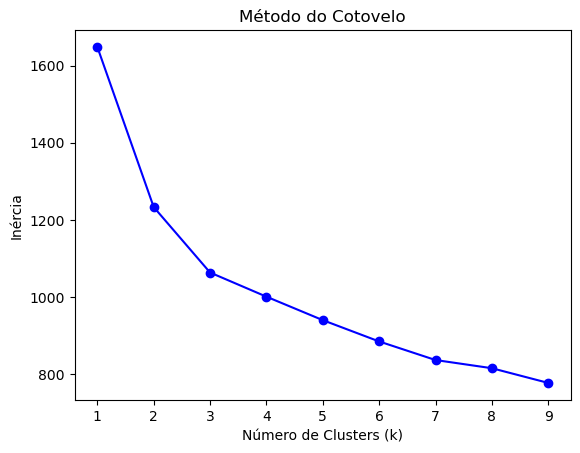

In [194]:
# Gráfico Curva do Cotovelo (ou Joelho)
inertia = []

# Testar diferentes valores de k
k_values = range(1, 10)
for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(x_train)
  inertia.append(kmeans.inertia_)

# Plotar a curva do método do cotovelo
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

#### Definindo o número de cluters desejados

In [203]:
num_clusters = 4 # 3 ou 4, com base no gráfico da curva do cotovelo
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(x_train)

labels = kmeans.labels_ # Obtendo os rótulos dos clusters para cada ponto de dados

# Realizando previsões para novos pontos de dados
predicted_cluster = kmeans.predict(x_test)
# predicted_groups = label_encoder.inverse_transform(predicted_cluster)
# print(predicted_groups)

# Calculando a distância entre dois pontos de dados
ponto1 = dados_oversampled.loc[0]
ponto2 = dados_oversampled.loc[1]
distancia = np.linalg.norm(ponto1 - ponto2)

# Embaralhando aleatoriamente o conjunto de dados
dados_oversampled = dados_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Selecionando aleatoriamente K pontos de dados
K = 4
dados_selecionados = dados_oversampled.sample(n=K, random_state=42)

c:\Users\saman\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\saman\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


#### Visualizando os clusters utilizando PCA

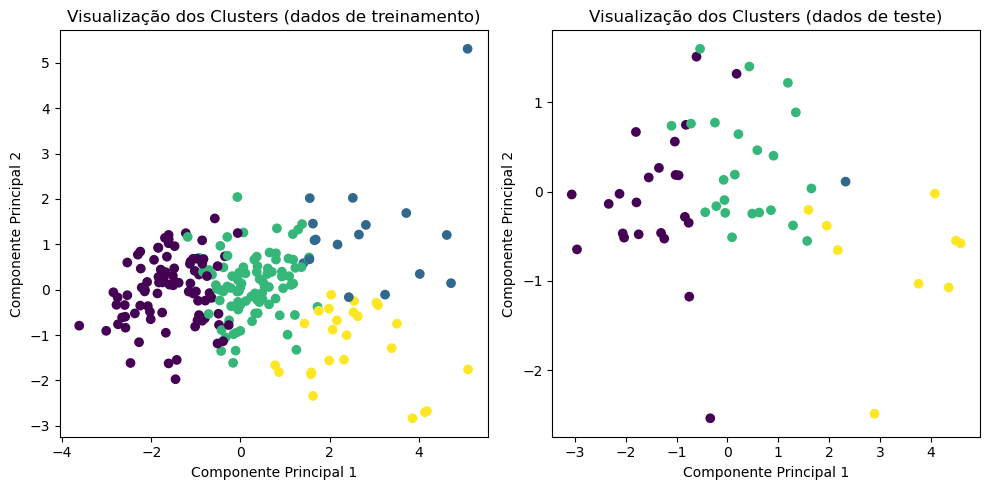

In [204]:
# Aplicar PCA para redução de dimensionalidade
pca = PCA(n_components=2)
x_pca_train = pca.fit_transform(x_train)
x_pca_test = pca.transform(x_test)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plotar o primeiro gráfico
axs[0].scatter(x_pca_train[:, 0], x_pca_train[:, 1], c=labels, cmap='viridis')
axs[0].set_xlabel('Componente Principal 1')
axs[0].set_ylabel('Componente Principal 2')
axs[0].set_title('Visualização dos Clusters (dados de treinamento)')

# Plotar o segundo gráfico
axs[1].scatter(x_pca_test[:, 0], x_pca_test[:, 1], c=predicted_cluster, cmap='viridis')
axs[1].set_xlabel('Componente Principal 1')
axs[1].set_ylabel('Componente Principal 2')
axs[1].set_title('Visualização dos Clusters (dados de teste)')

# Ajustar os espaçamentos entre os subplots
plt.tight_layout()

# Exibir a figura com os subplots
plt.show()

#### Contando a frequência de cada rótulo de cluster

Cluster Foundation Stock Service: 86 pontos de dados
Cluster Herding Group: 17 pontos de dados
Cluster Hound Group: 93 pontos de dados
Cluster Miscellaneous Class: 25 pontos de dados


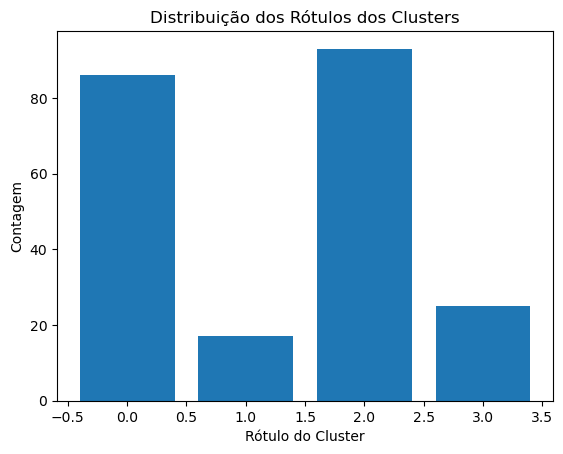

In [211]:
cluster_labels, cluster_counts = np.unique(labels, return_counts=True)

predicted_groups_names = label_encoder.inverse_transform(cluster_labels)

# Imprimir o nome e a contagem de cada cluster
for name, count in zip(predicted_groups_names, cluster_counts):
    print(f"Cluster {name}: {count} pontos de dados")


# Plotar a distribuição dos rótulos dos clusters
plt.bar(cluster_labels, cluster_counts)
plt.xlabel('Rótulo do Cluster')
plt.ylabel('Contagem')
plt.title('Distribuição dos Rótulos dos Clusters')
plt.show()

## Questão 6
Faça a comparação dos resultados (item 3, 4 e 5) utilizando pelo menos 2 métricas. Justifique a escolha dessas métricas e argumente sobre os resultados encontrados. Para tanto, você pode fazer um uso de gráficos e matrizes de confusão.


### Resolução

Os comparativos já foram realizados dentro das próprias questões.